This is a reproduction of the project from: 
https://www.kaggle.com/code/gabrielsober/diabetes-eda-prediction

Some modifications were added to be used for analysis between projects and to run the projects locally.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# for EDA
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors
import matplotlib.ticker as mtick

# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression, f_classif, chi2

# feature scaler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# for fixing the imbalanced dataset and split
from sklearn.model_selection import train_test_split

# for model evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

# models selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# for the gridsearch
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## If you like this notebook and want to use the code or graph style, remember to upvote! Its help other to find this notebook and help me!

# Loading datasets

There 3 dataset:

* df1, dataset with data from patients without diabetes, pre-diabetes and diabetes
* df2, balanced patients with and without diabetes
* df3, imbalanced dataset of patients with and without diabetes

This analysis will work with the last 2, where we will explore df3 imbalanced and large dataset to understand the features and target relationship. We will use this information to predict patients in balanced dataset df2.

In [2]:
# loading data
# df1 = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv')
df2 = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv.zip')
df3 = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv.zip')
 

# print('df1 shape is: {}'.format(df1.shape))
print('df2 shape is: {}'.format(df2.shape))
print('df3 shape is: {}'.format(df3.shape))


df2 shape is: (70692, 22)
df3 shape is: (253680, 22)


# Dataset Before cleanup

In [3]:
df3.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

# Cleaning the dataset

## Missing Values

In [5]:
# checking if there missing values
df3.isna().sum() 

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

No missing value

In [6]:
df3.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,253680.0,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


## Checking Duplicates

In [7]:
duplicates = df3[df3.duplicated()]
print("Duplicate Rows : ",len(duplicates))
duplicates.head()

Duplicate Rows :  24206


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1242,1.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0


In [8]:
def data_clean(dataframe):
    
    bins = [0, 18.5, 24.9, 29.9, float('inf')]
    labels = [1,2,3,4]
    
    df = (dataframe
         .drop_duplicates()
         .assign(BMI_bins=dataframe.BMI.pipe(pd.cut, bins=bins, labels=labels))
         .reset_index(drop=True)
         .astype({'Diabetes_binary':'uint8',
     'HighBP':'uint8',
     'HighChol':'uint8',
     'CholCheck':'uint8',
     'BMI':'uint8',
     'Smoker':'uint8',
     'Stroke':'uint8',
     'HeartDiseaseorAttack':'uint8',
     'PhysActivity':'uint8',
     'Fruits':'uint8',
     'Veggies':'uint8',
     'HvyAlcoholConsump':'uint8',
     'AnyHealthcare':'uint8',
     'NoDocbcCost':'uint8',
     'GenHlth':'uint8',
     'MentHlth':'uint8',
     'PhysHlth':'uint8',
     'DiffWalk':'uint8',
     'Sex':'uint8',
     'Age':'uint8',
     'Education':'uint8',
     'Income':'uint8',
     'BMI_bins':'uint8'}) 
          
          
         )
    return df

In [9]:
df = data_clean(df3)
df2_clean = data_clean(df2)

Quick note: 

Using uint8 will reduce DataFrame memory size without lose information and helps for classification models interpretation later. (better than boolean)

# Dataset After the cleanup

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229474 entries, 0 to 229473
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_binary       229474 non-null  uint8
 1   HighBP                229474 non-null  uint8
 2   HighChol              229474 non-null  uint8
 3   CholCheck             229474 non-null  uint8
 4   BMI                   229474 non-null  uint8
 5   Smoker                229474 non-null  uint8
 6   Stroke                229474 non-null  uint8
 7   HeartDiseaseorAttack  229474 non-null  uint8
 8   PhysActivity          229474 non-null  uint8
 9   Fruits                229474 non-null  uint8
 10  Veggies               229474 non-null  uint8
 11  HvyAlcoholConsump     229474 non-null  uint8
 12  AnyHealthcare         229474 non-null  uint8
 13  NoDocbcCost           229474 non-null  uint8
 14  GenHlth               229474 non-null  uint8
 15  MentHlth              229474 non-n

In [11]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,229474.0,0.152945,0.359936,0.0,0.0,0.0,0.0,1.0
HighBP,229474.0,0.454343,0.497912,0.0,0.0,0.0,1.0,1.0
HighChol,229474.0,0.441640,0.496584,0.0,0.0,0.0,1.0,1.0
CholCheck,229474.0,0.959481,0.197173,0.0,1.0,1.0,1.0,1.0
BMI,229474.0,28.687507,6.789204,12.0,24.0,27.0,32.0,98.0
Smoker,229474.0,0.465800,0.498830,0.0,0.0,0.0,1.0,1.0
Stroke,229474.0,0.044816,0.206899,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,229474.0,0.103336,0.304398,0.0,0.0,0.0,0.0,1.0
PhysActivity,229474.0,0.733042,0.442371,0.0,0.0,1.0,1.0,1.0
Fruits,229474.0,0.612675,0.487140,0.0,0.0,1.0,1.0,1.0


# Grouping variables

In [12]:
# grouped variables
target = 'Diabetes_binary'
bool_vars = (df3.nunique()[df3.nunique() == 2]
                .index
                .drop(labels='Diabetes_binary'))
num_vars = [var for var in df.columns if var not in bool_vars and var != 'Diabetes_binary']

# EDA : Target

Diabetes_binary
1     35097
0    194377
Name: count, dtype: int64
Diabetes_binary
1    15.294543%
0    84.705457%
Name: proportion, dtype: object



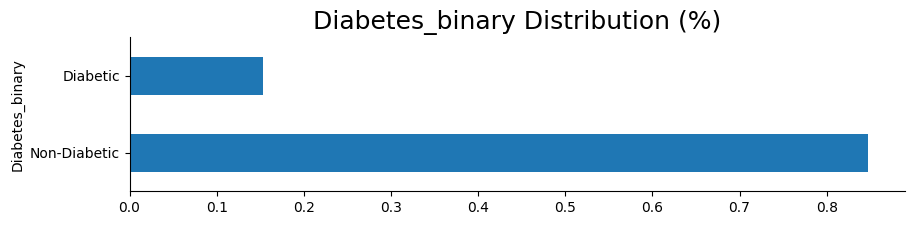

In [13]:
print(df['Diabetes_binary'].value_counts(ascending=True))
print(df['Diabetes_binary'].value_counts(1,ascending=True).apply(lambda x: format(x, '%')))
print()
df['Diabetes_binary'].value_counts(1).plot(kind='barh',figsize=(10, 2)).spines[['top', 'right']].set_visible(False);
plt.title('Diabetes_binary Distribution (%)', fontsize=18)
plt.yticks(ticks=[0,1], labels=['Non-Diabetic', 'Diabetic']);

~15% of the cleaned dataset has diabetes. **Imbalanced** dataset.

# EDA : Category variables

In [14]:
colors = ['#be4d25','#2596be']
def analyse_cat(var):
    (df.groupby('Diabetes_binary')[var]
     .value_counts(1)
     .unstack()
     .iloc[:,::-1]
     .plot(kind='barh',stacked=True,figsize=(10, 2), color=colors, alpha=1)
     .spines[['top', 'right']].set_visible(False))
    plt.legend(['Yes', "No"],bbox_to_anchor=(1, 1, 0, 0),shadow=False, frameon=False)
    plt.yticks(ticks=[0,1], labels=['Non-Diabetic', 'Diabetic'])
    plt.tight_layout()
    plt.title(var, fontsize=18)
    plt.show()

In the graphs below, Its possible to quick check the *percentage* that represents each categorical variable for people **with** and **without diabetes**.

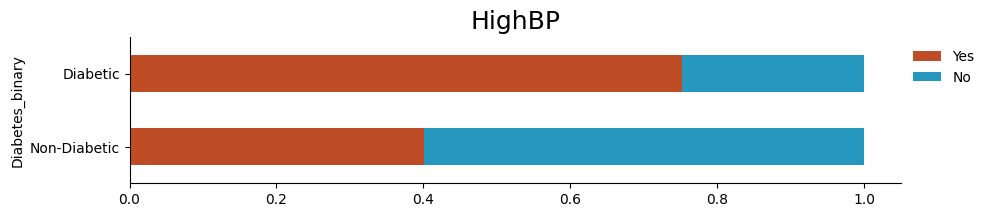

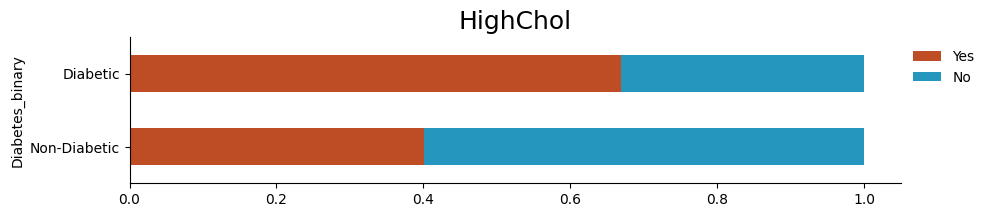

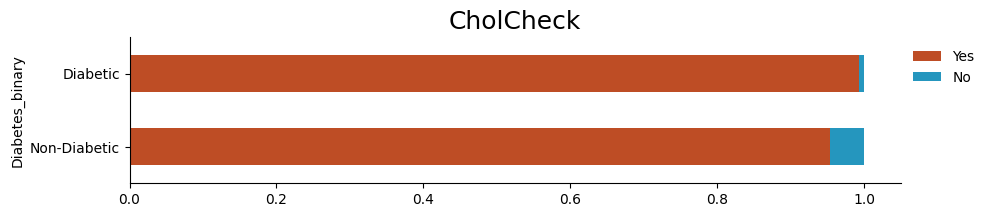

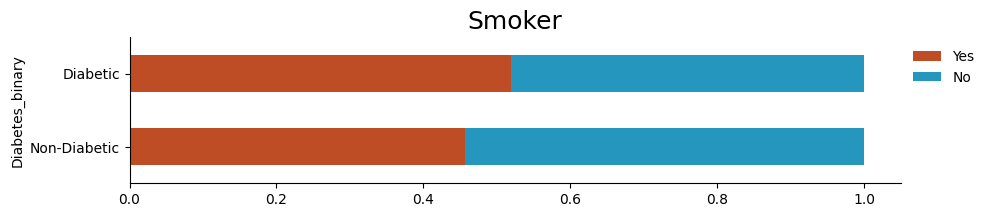

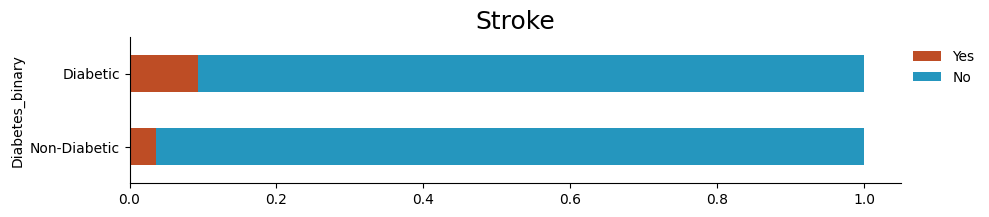

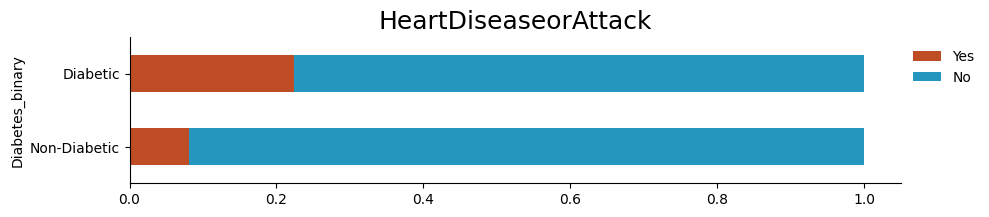

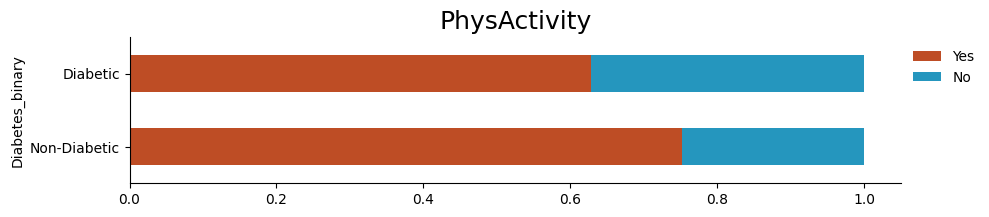

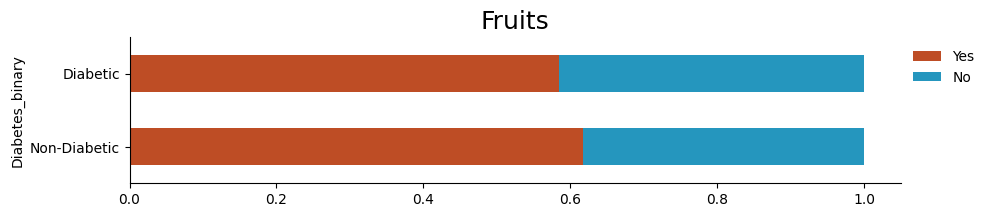

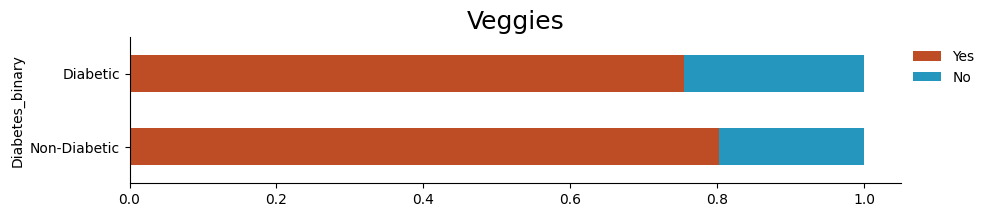

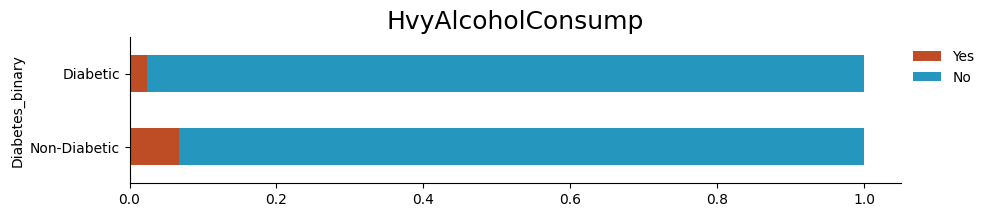

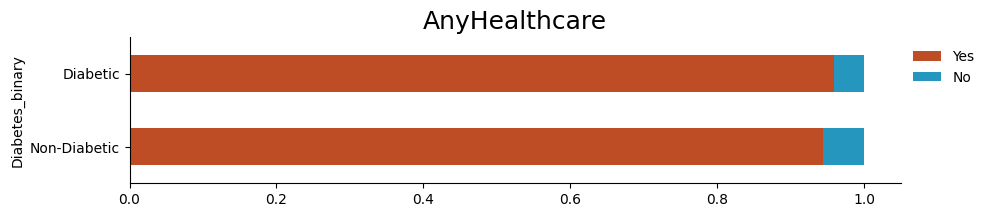

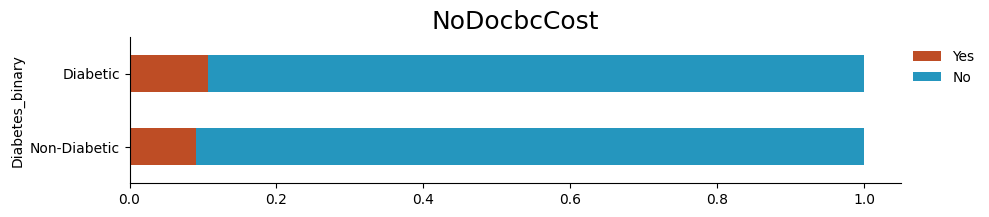

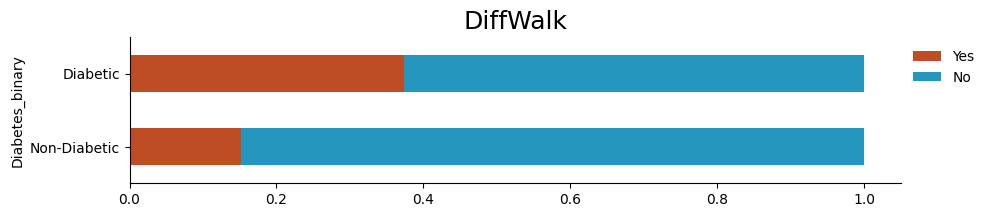

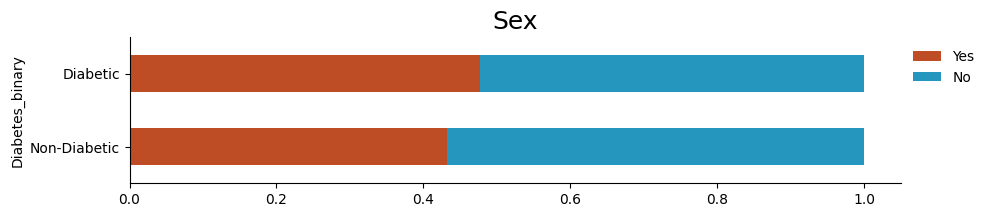

In [15]:
for var in bool_vars:
    analyse_cat(var)

Note:

In variable Sex, yes = Male, No = Female

# EDA: Numeric non-binary Variables

In [16]:
df[num_vars].describe()

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income,BMI_bins
count,229474.000000,229474.000000,229474.000000,229474.000000,229474.000000,229474.000000,229474.000000,229474.000000
mean,28.687507,2.601820,3.509866,4.681219,8.085068,4.979741,5.888615,3.086768
std,6.789204,1.064962,7.717643,9.050877,3.094451,0.992989,2.092888,0.819686
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,24.000000,2.000000,0.000000,0.000000,6.000000,4.000000,4.000000,2.000000
50%,27.000000,3.000000,0.000000,0.000000,8.000000,5.000000,6.000000,3.000000
75%,32.000000,3.000000,2.000000,4.000000,10.000000,6.000000,8.000000,4.000000
max,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000,4.000000


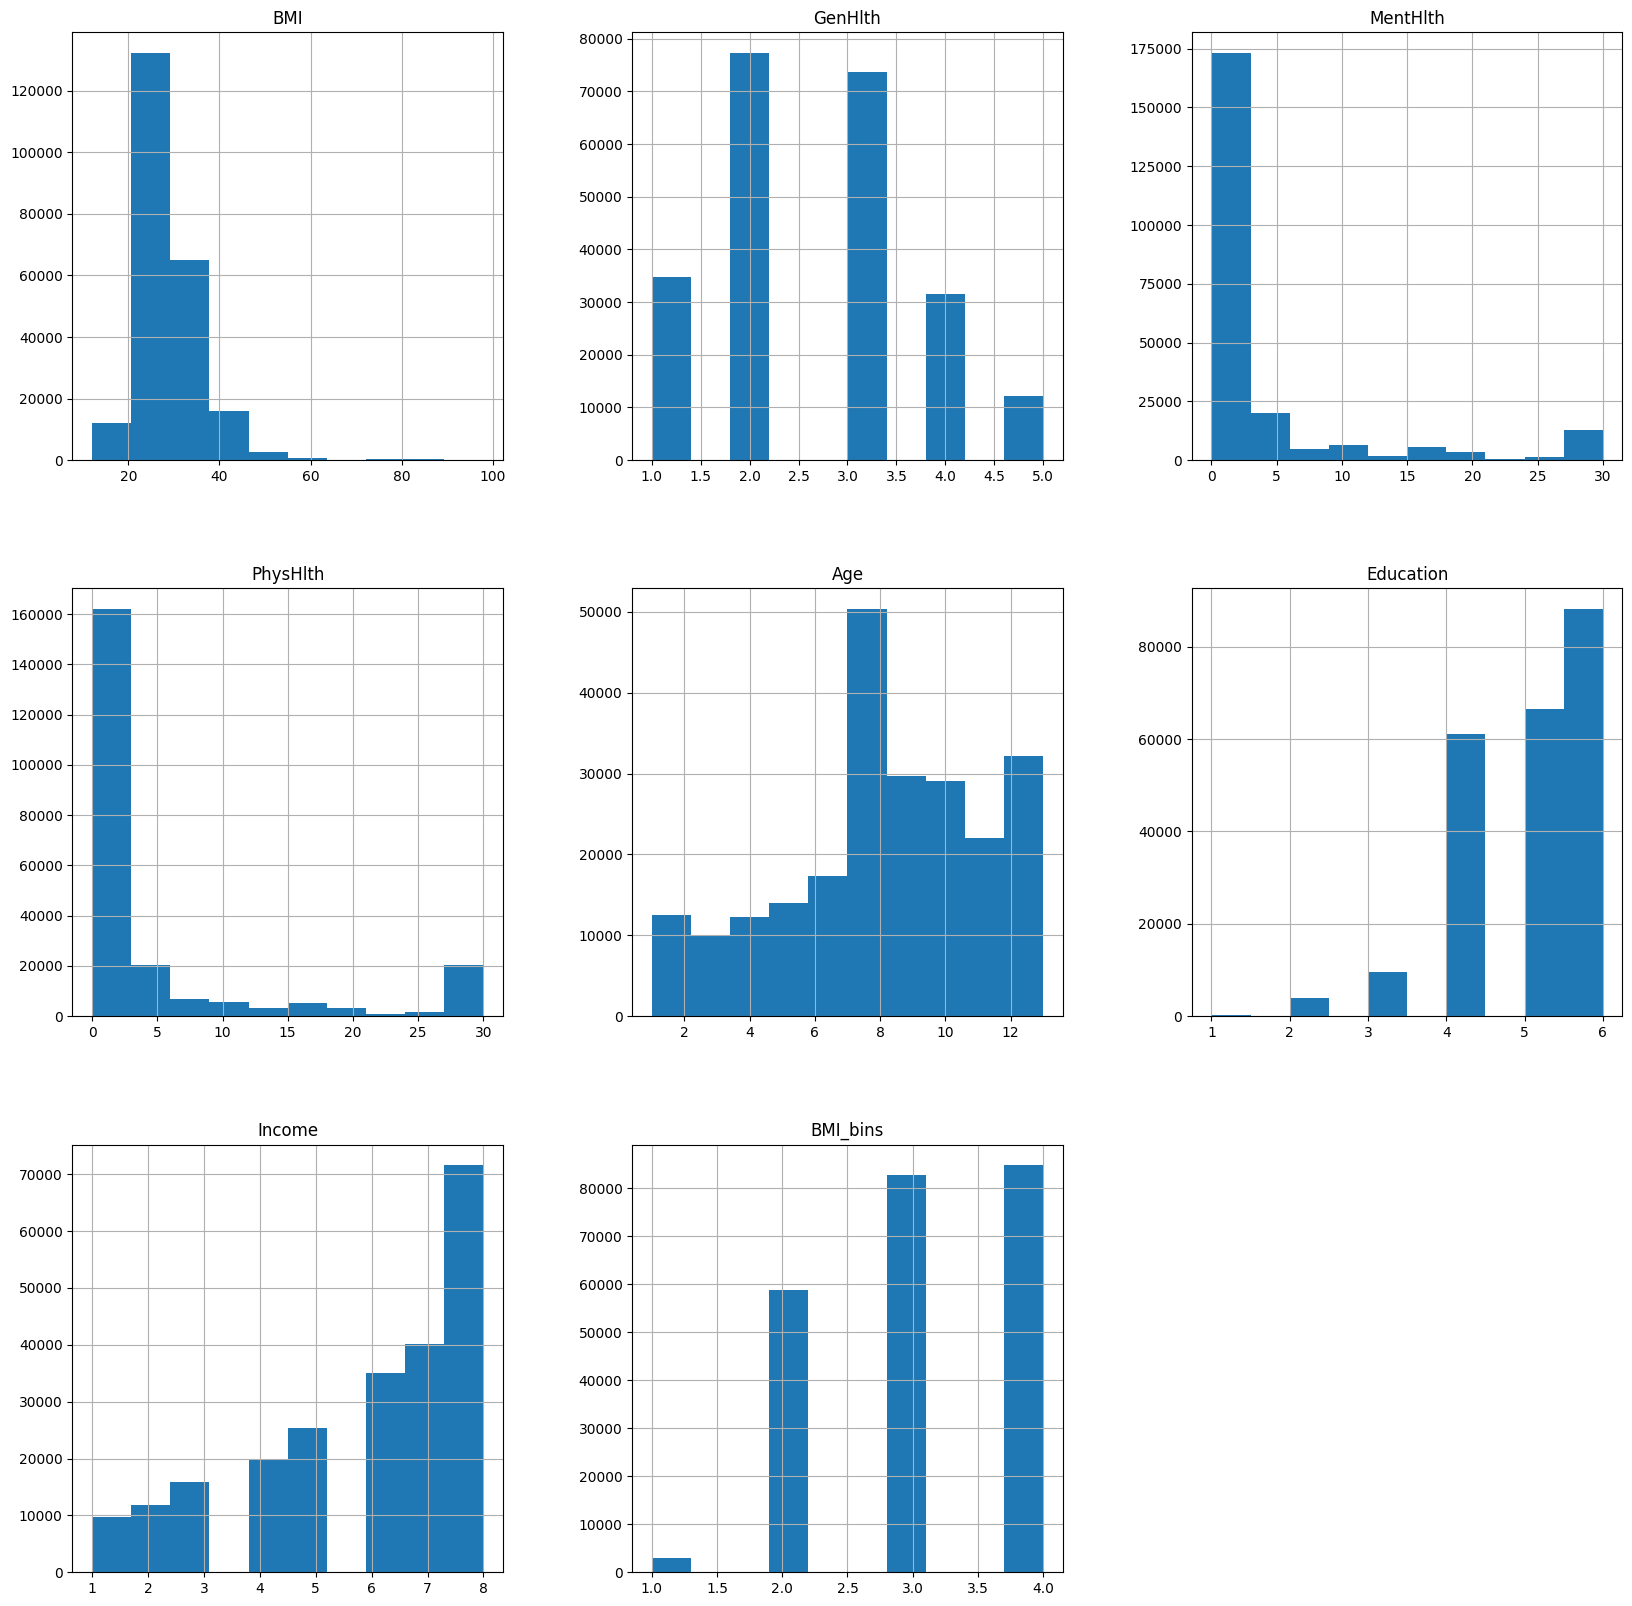

In [17]:
df[num_vars].hist(figsize=(20,20));

Preview of the numeric variables distribution

# Number of unique values

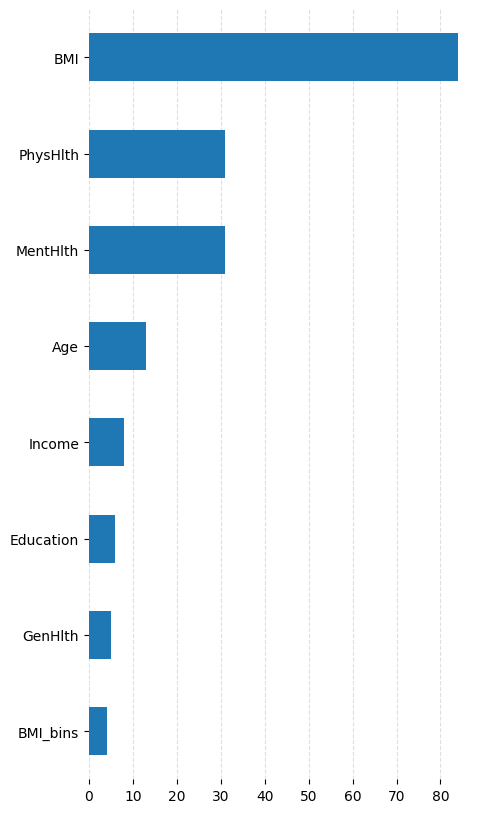

In [18]:
(df[num_vars]
 .nunique()
 .sort_values(ascending=True)
.plot(kind='barh', figsize=(5,10), zorder=3)).spines[['top','right', 'left', 'bottom']].set_visible(False)
plt.grid(axis='x', linestyle='--', alpha=.4)

BMI seems to be continuous values, PhysHlth and MentHlth are both at 30, can be a month related variable. Age, Income, Education and GenHlth seems to be hierarchical categories.

# Relationship between variables

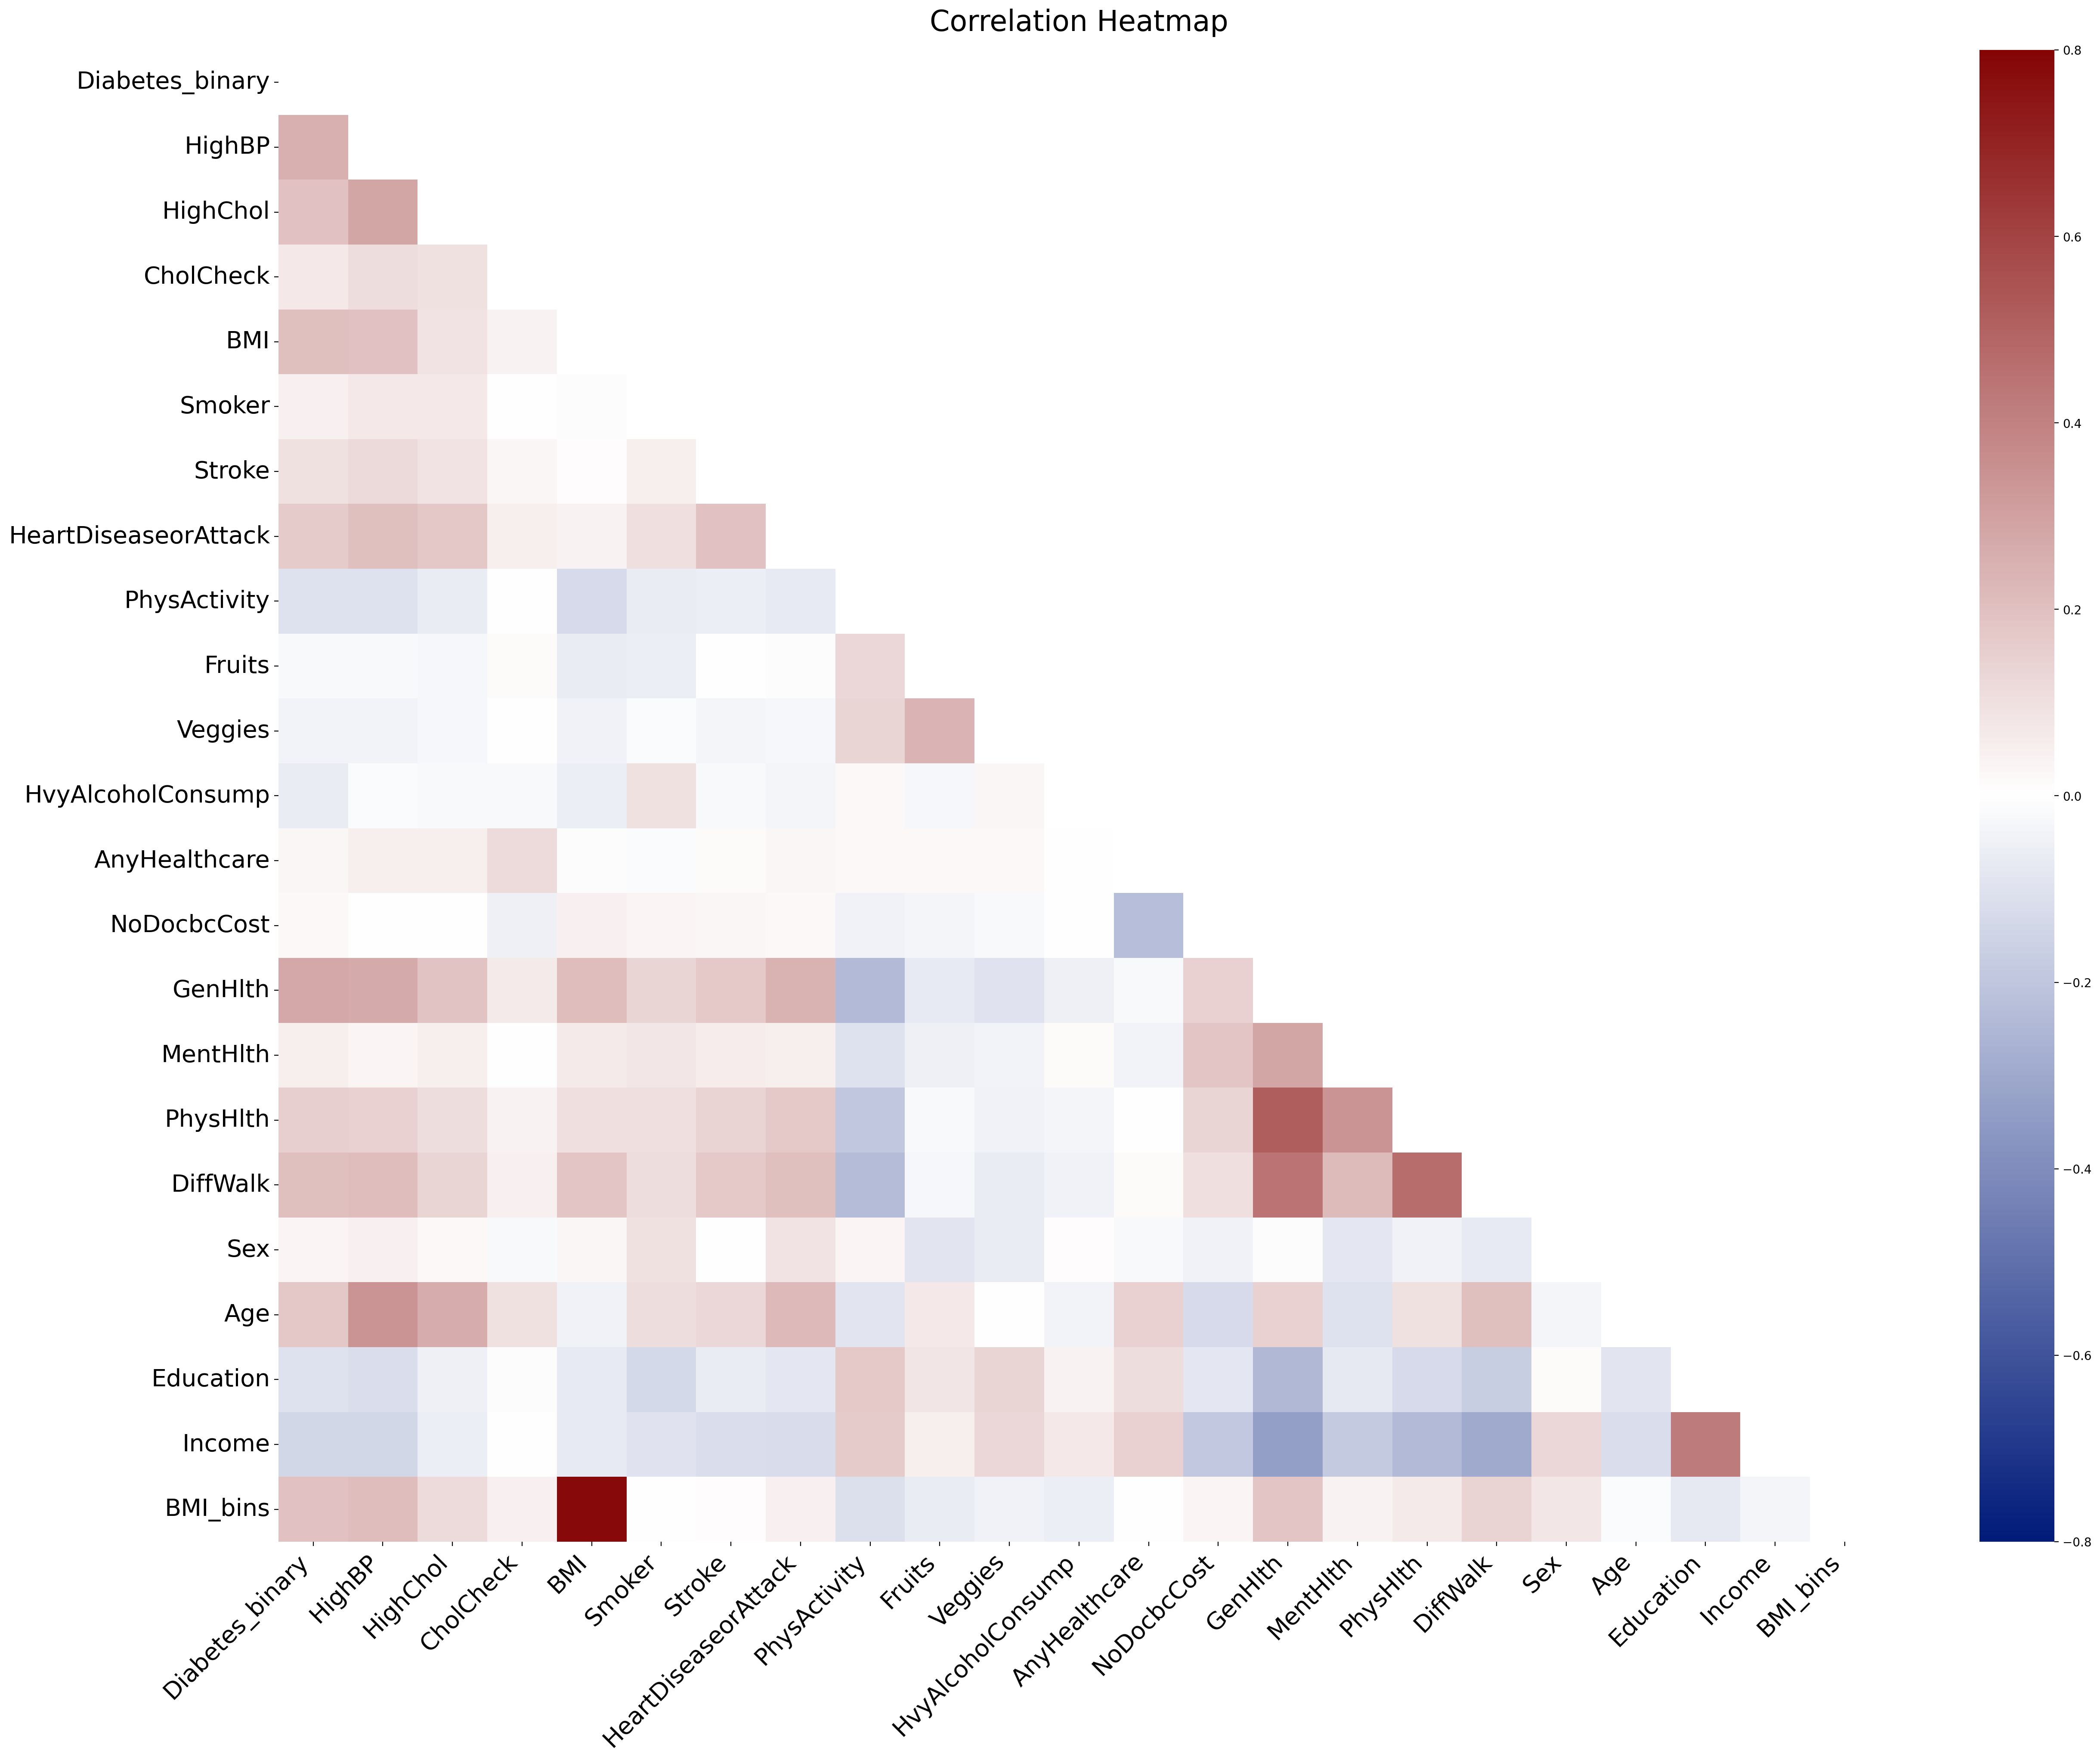

In [19]:
data_heatmap = df
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#011b7a', 'white', '#850505'])

mask = np.triu(np.ones_like(data_heatmap.corr(), dtype=bool))

lenghtsize = 30
fig, ax = plt.subplots(figsize=(lenghtsize,lenghtsize*.75), dpi=200)

heatmap = sns.heatmap(data_heatmap.corr(), cmap=custom_cmap, mask=mask, annot=False, vmin=-.8, vmax=.8)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':24}, pad=16);
ax.tick_params(axis='both', which='major', labelsize=20)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right');

## Strong Correlations:

* Variables Physical Health and General Health correlated positivily

BMI_bins was extracted from BMI (ignore this for now)

The analysis revealed a significant positive correlation between the Physical Health and General Health variables, suggesting that General Health may be a composite measure comprising Physical Health Sum and other related factors.

* Variables Income and General Health correlated negativily

Furthermore, the analysis indicated a negative correlation between Income and General Health, implying that individuals with lower incomes may experience limited access to private medical care, potentially leading to negative impacts on their overall health outcomes.

# Correlations with Target

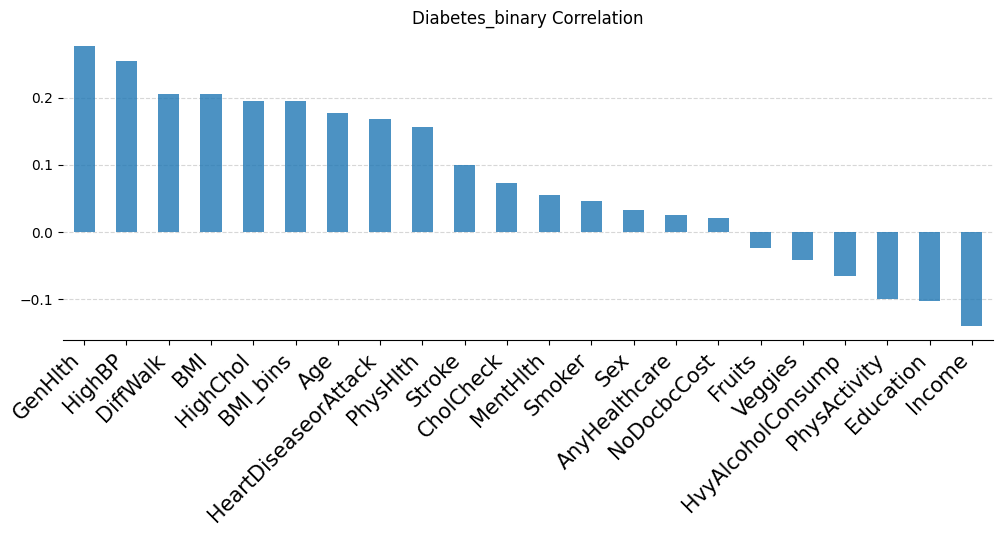

In [20]:
(df.drop('Diabetes_binary', axis=1)
   .corrwith(df.Diabetes_binary)
   .sort_values(ascending=False)
   .plot(kind='bar', figsize=(12, 4), title="Diabetes_binary Correlation", alpha=0.8, zorder=3)
   .spines[['top','right', 'left']].set_visible(False)
   )
plt.grid(axis='y', linestyle='--', alpha=.5)
plt.xticks(rotation = 45, ha='right', size=15);


This variables have more correlated with the target variable **Diabetes_binary**
* GenHlth
* HighBP
* DiffWalk
* BMI
* HighChol
* Age
* HeartDiseaseorAttack
* PhysHlth
* Physactivity
* Education
* Income

This variables that have a very weak correlation
* AnyHealthcare
* NoDocbcCost
* Fruits
* Sex
* Smoker
* Veggies


# What represent this more correlated variables?

## GenHlth
The metadata of the dataset indicates that patients were asked to rate their overall health status on a 1-5 scale, where:

* 1 = Excellent
* 2 = very good
* 3 = good
* 4 = fair
* 5 = poor

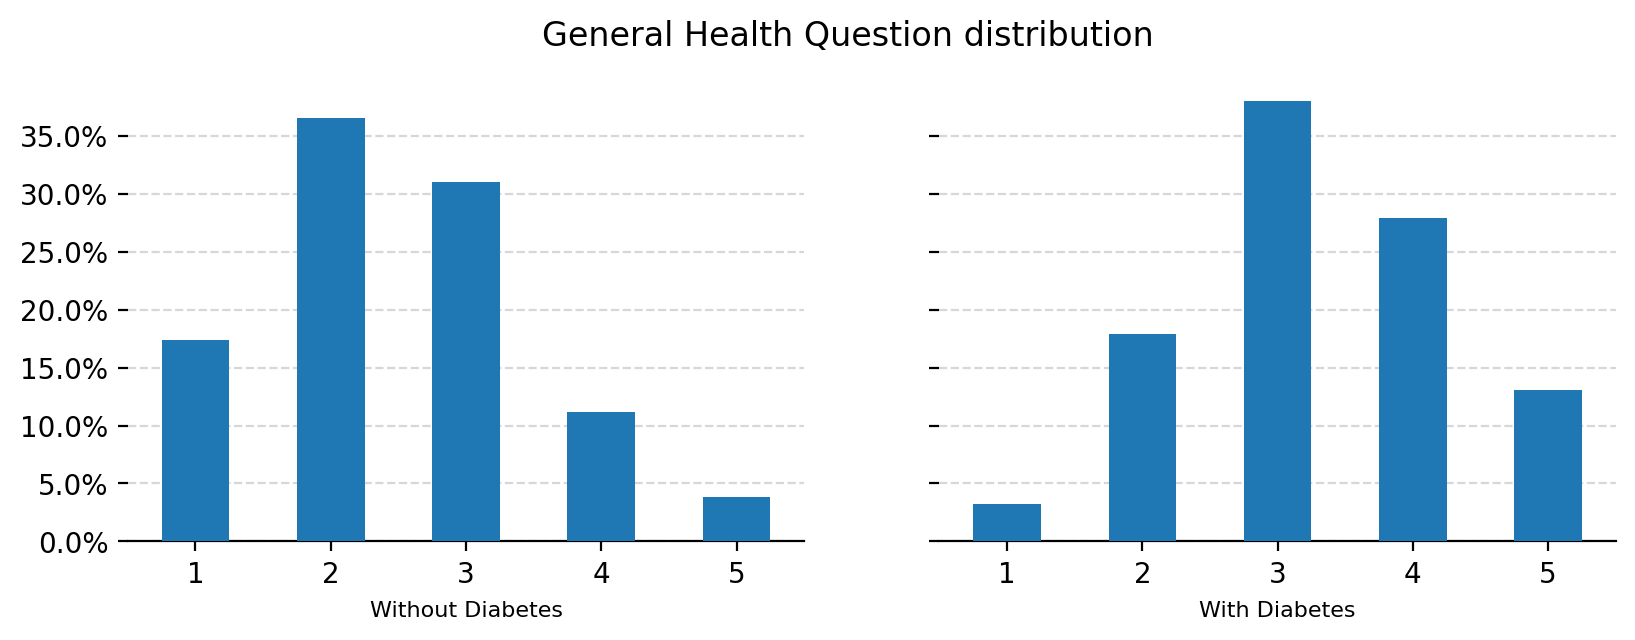

In [21]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('General Health Question distribution')

(df[df['Diabetes_binary']==False]['GenHlth']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

(df[df['Diabetes_binary']==True]['GenHlth']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

According to self-reported data from the dataset, individuals with diabetes perceive a significantly lower level of well-being compared to those without the condition.

# HighBP
MetaData explains that is patient Blood pressure classification.


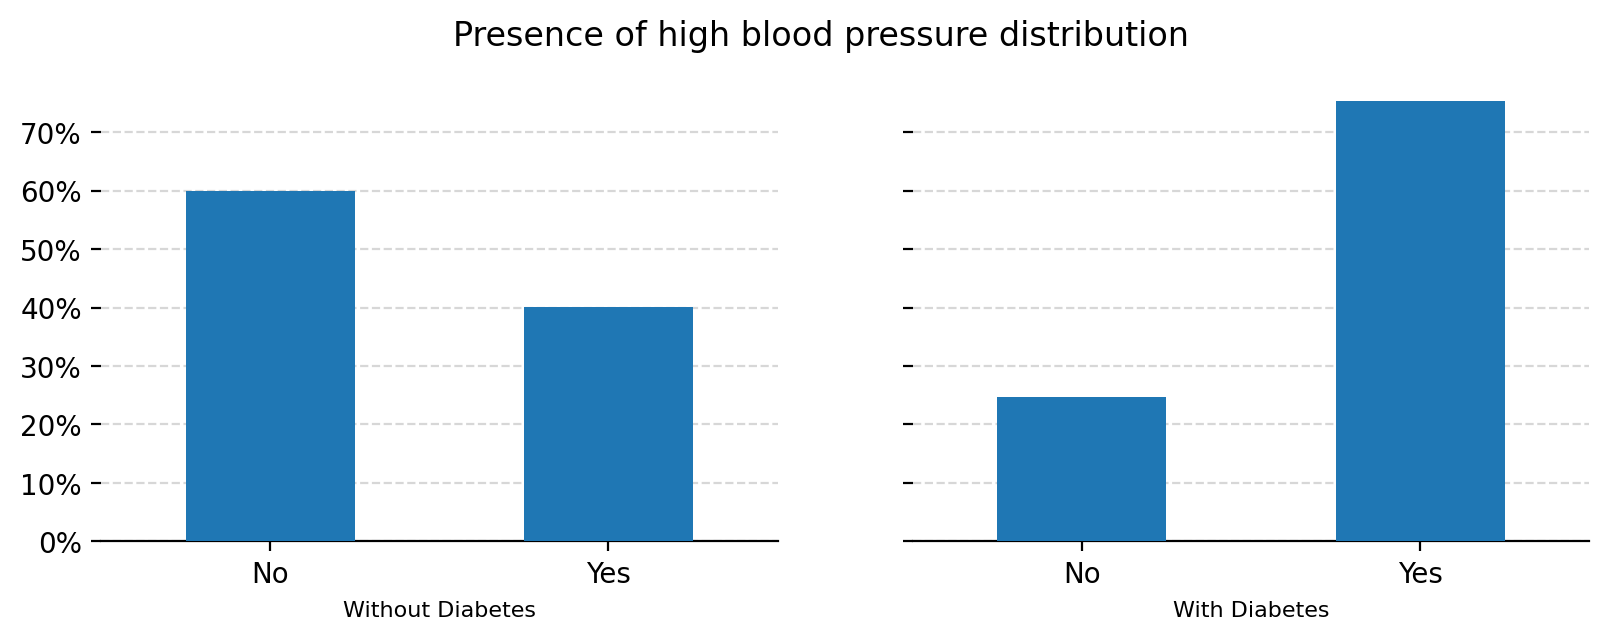

In [22]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Presence of high blood pressure distribution')

(df[df['Diabetes_binary']==False]['HighBP']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

(df[df['Diabetes_binary']==True]['HighBP']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

The analysis of the dataset indicates that individuals diagnosed with Diabetes exhibit a significantly greater incidence of hypertension compared to those without the condition

# DiffWalk

Patients where asked: *'Do you have serious difficulty walking or climbing stairs?'*


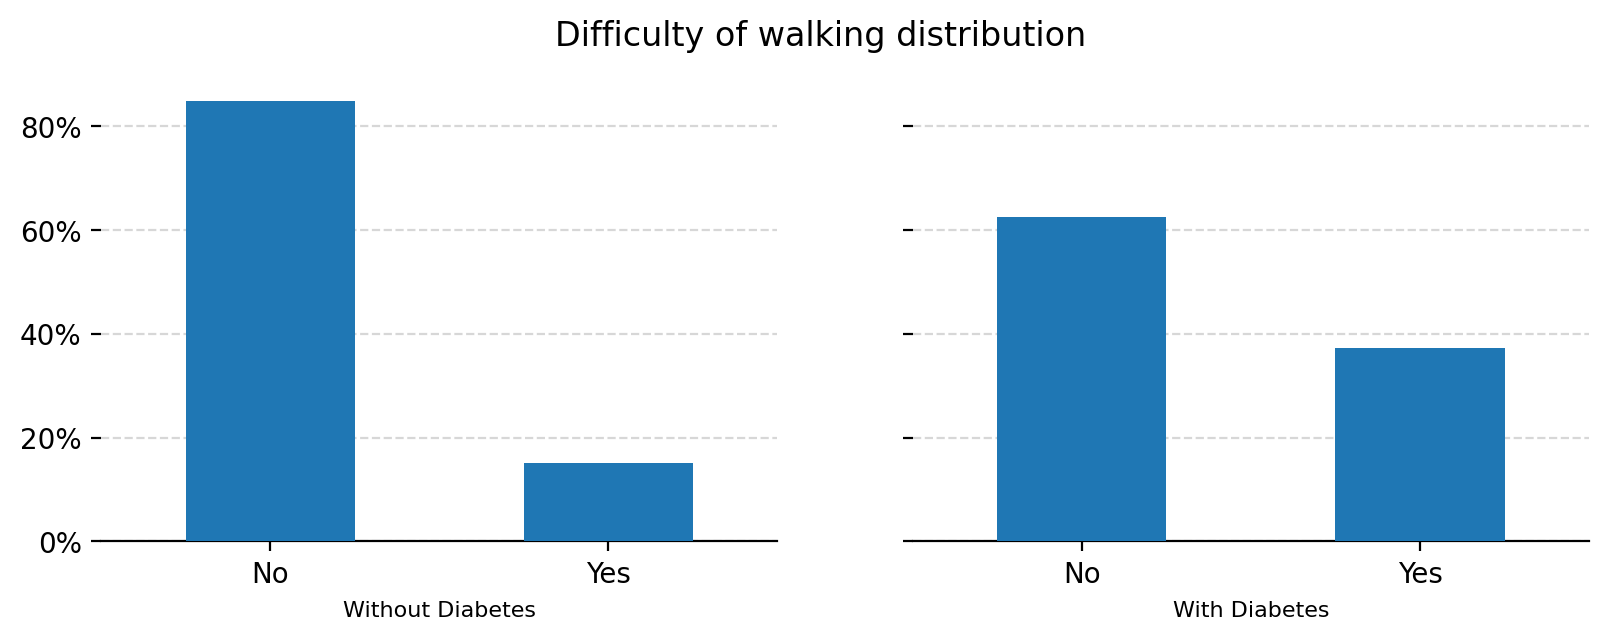

In [23]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Difficulty of walking distribution')

(df[df['Diabetes_binary']==False]['DiffWalk']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

(df[df['Diabetes_binary']==True]['DiffWalk']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

The analysis of the dataset indicates that individuals diagnosed with Diabetes exhibit a significantly greater difficulty walking compared to those without the condition

# BMI
Body Mass Index (BMI) is a measure of body fat based on a person's weight and height. It is calculated by dividing a person's weight in kilograms by the square of their height in meters (kg/m²).

\begin{equation}
BMI = \frac{weight \ (kg)}{height^2 \ (m^2)}
\end{equation}

BMI provides an estimation of the amount of body fat a person has, and is commonly used as a screening tool to identify individuals who may be at a higher risk for weight-related health problems, such as diabetes, heart disease, and certain types of cancer.

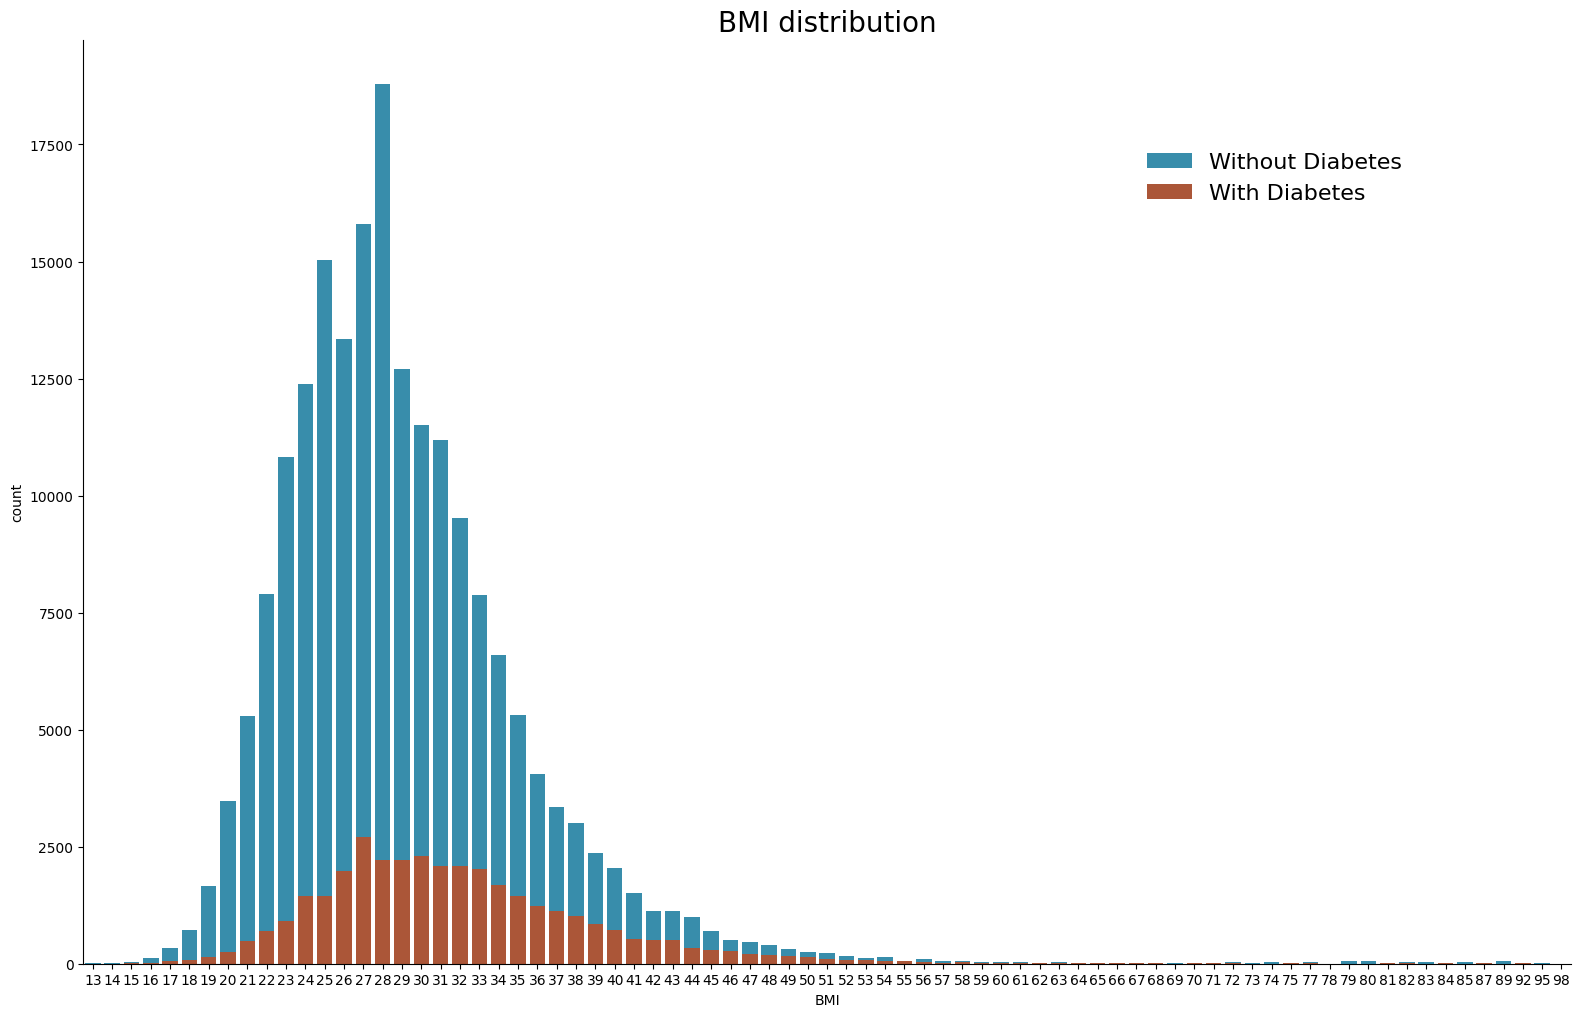

In [24]:
ratio = 12
plt.figure(figsize=(ratio*1.6,ratio))
colors = ['#be4d25','#2596be']

sns.countplot(x=(df[df['Diabetes_binary']==False]['BMI']), color=colors[1], label="Without Diabetes")
sns.countplot(x=(df[df['Diabetes_binary']==True]['BMI']), color=colors[0], label="With Diabetes" )
sns.despine()
plt.title("BMI distribution", size=20)
plt.legend(bbox_to_anchor=(.9, .9, 0, 0),shadow=False, frameon=False, prop={'size':16});


## How is BMI interpreted for adults?

According with CDC:

For adults 20 years old and older, BMI is interpreted using standard weight status categories. These categories are the same for men and women of all body types and ages.

* If your BMI is less than 18.5, it falls within the underweight range.
* If your BMI is 18.5 to 24.9, it falls within the Healthy Weight range.
* If your BMI is 25.0 to 29.9, it falls within the overweight range.
* If your BMI is 30.0 or higher, it falls within the obese range.

A new column was created with this range names.


In [25]:
# This feature extreaction is already in the df_clean function, this is left to educational proposes.

# create new binned column 
# bins = [0, 18.5, 24.9, 29.9, float('inf')]
# 
# df['BMI_bins'] = pd.cut(df['BMI'], bins=bins, labels=labels)

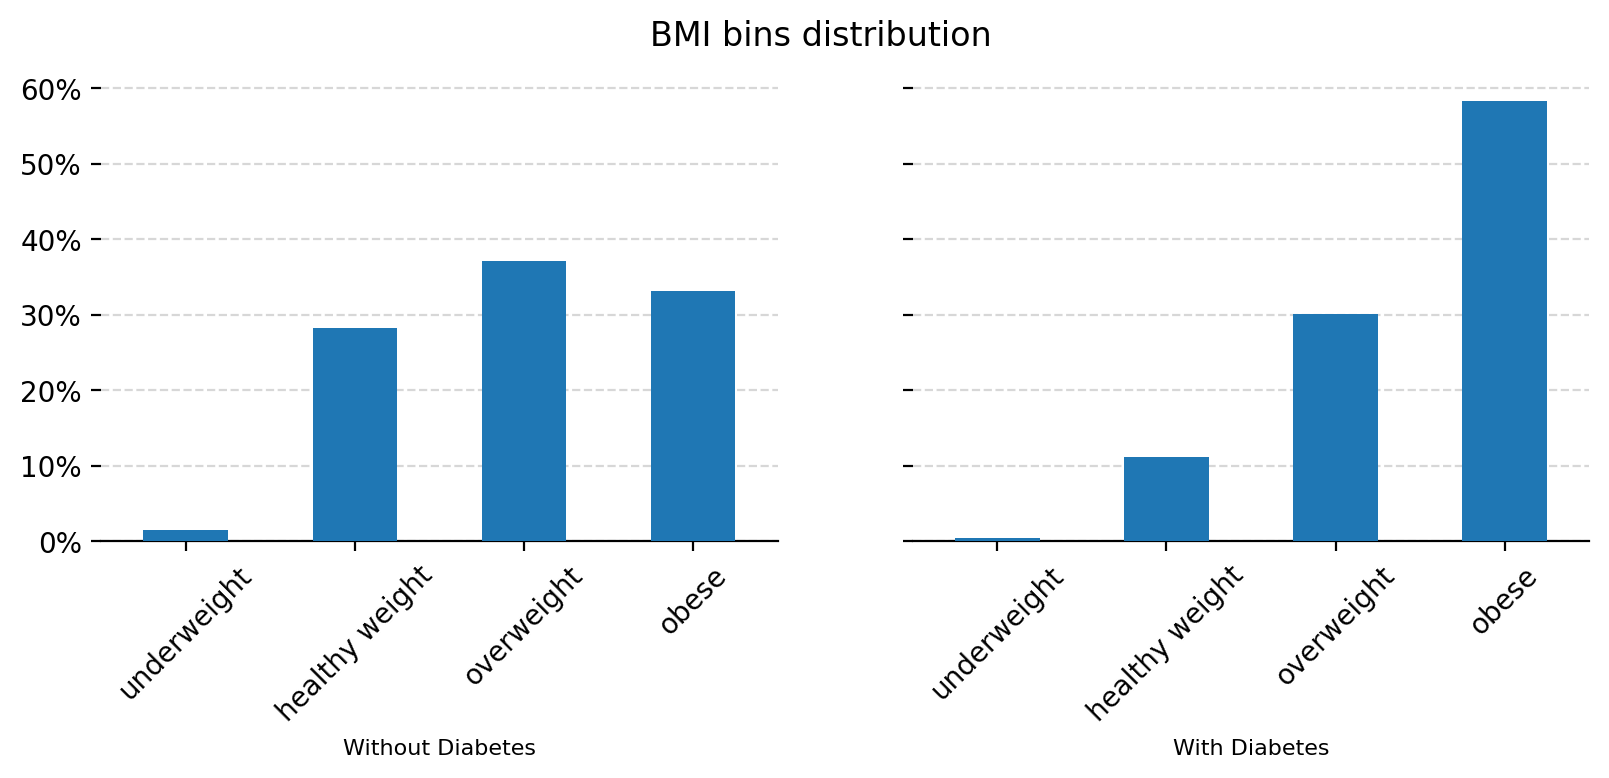

In [26]:
labels = ['underweight', 'healthy weight', 'overweight', 'obese']
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('BMI bins distribution')

(df[df['Diabetes_binary']==False]['BMI_bins']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xticklabels(labels)
ax.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

(df[df['Diabetes_binary']==True]['BMI_bins']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.set_xticklabels(labels)
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45);

The analysis indicates that there is no significant correlation between BMI bins and the group without diabetes, whereas a strong positive correlation between diabetes and obesity was observed.

# HighChol

MetaData explains that is patient cholesterol classification.


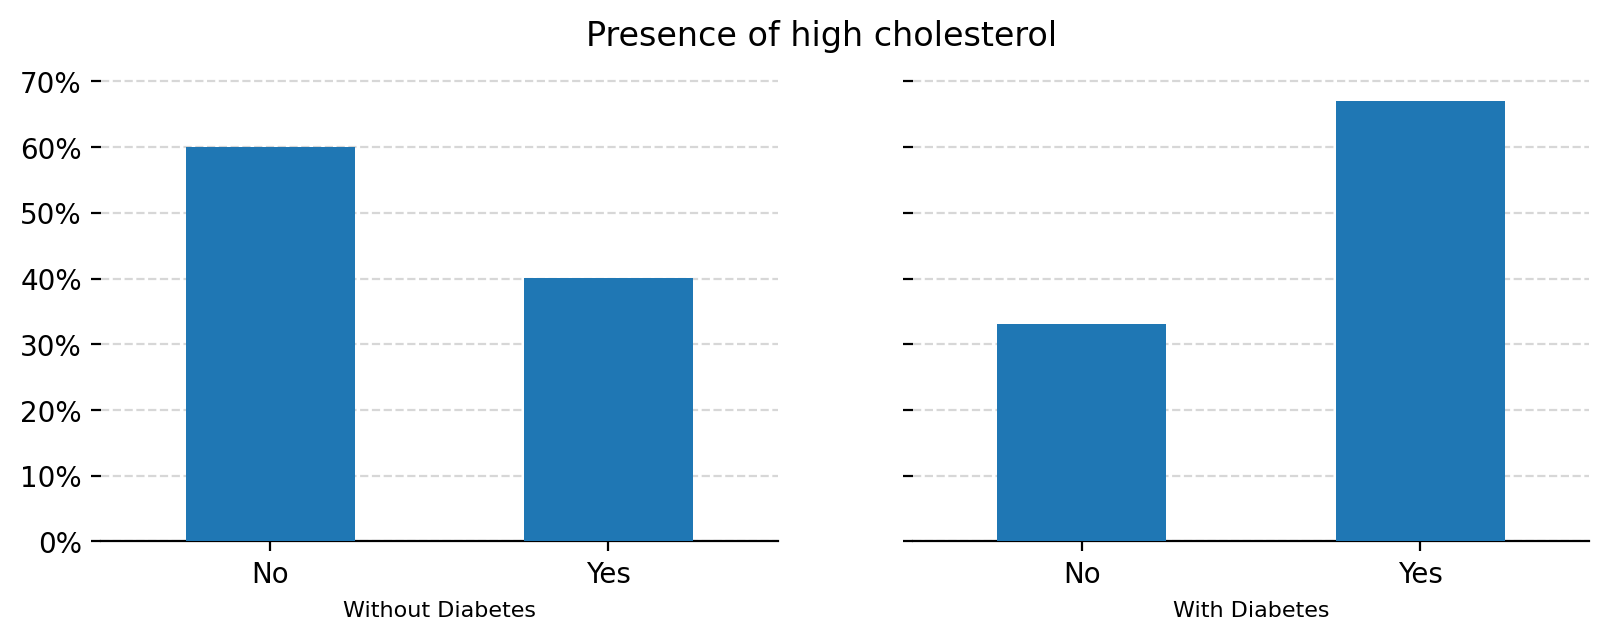

In [27]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Presence of high cholesterol')

(df[df['Diabetes_binary']==False]['HighChol']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

(df[df['Diabetes_binary']==True]['HighChol']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

The analysis of the dataset indicates that individuals diagnosed with Diabetes exhibit a significantly higher cholesterol compared to those without the condition

# Age

MetaData explains that is patient age classification with 5 year increments, where:

* 1 = 18-24 years old
* 2 = 25-29 years old
* 3 = 30-34 years old
* 4 = 35-39 years old
* 5 = 40-44 years old
* 6 = 45-49 years old
* 7 = 50-54 years old
* 8 = 55-59 years old
* 9 = 60-64 years old
* 10 = 65-69 years old
* 11 = 70-74 years old
* 12 = 75-79 years old
* 13 = 80 years and older


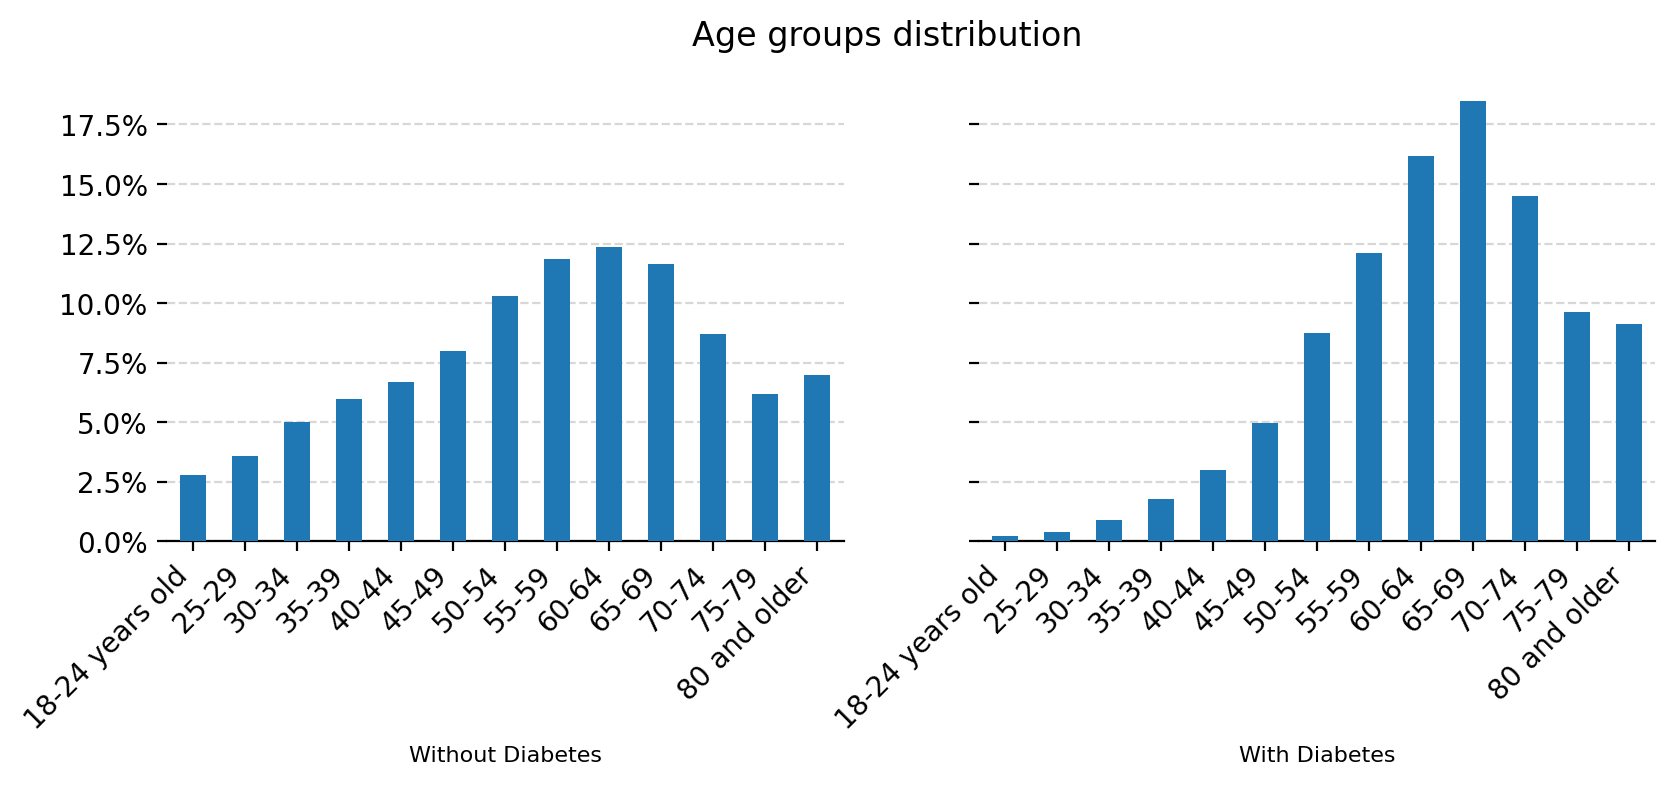

In [28]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Age groups distribution')
age_groups = ['18-24 years old', '25-29', '30-34', 
              '35-39', '40-44', '45-49', '50-54', 
              '55-59', '60-64', '65-69', '70-74', 
              '75-79', '80 and older']


(df[df['Diabetes_binary']==False]['Age']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(age_groups)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

(df[df['Diabetes_binary']==True]['Age']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(age_groups)
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right');

According to the dataset analysis, there was a notable concentration of individuals diagnosed with Diabetes between the ages of 50 to 74 years, in contrast to those without the condition.

# HeartDiseaseorAttack

MetaData explains that is patient condition presence coronary heart disease (CHD) or myocardial infarction (MI).

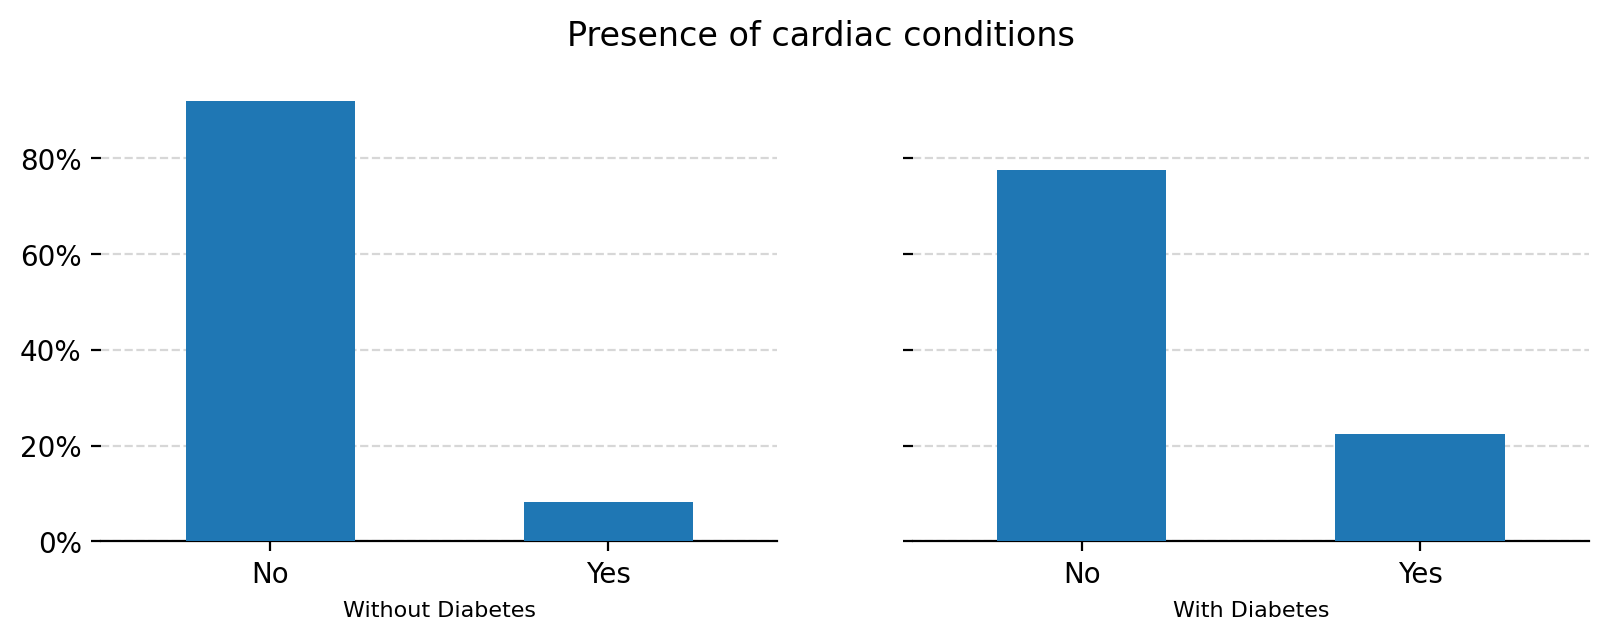

In [29]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Presence of cardiac conditions')

(df[df['Diabetes_binary']==False]['HeartDiseaseorAttack']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

(df[df['Diabetes_binary']==True]['HeartDiseaseorAttack']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);


The analysis of the dataset indicates that individuals diagnosed with Diabetes exhibit a significantly cardiac conditions increase compared to those without the condition

# PhysHlth
MetaData explains that is patient presence of physical illness and injury, for how many days during the past 30.


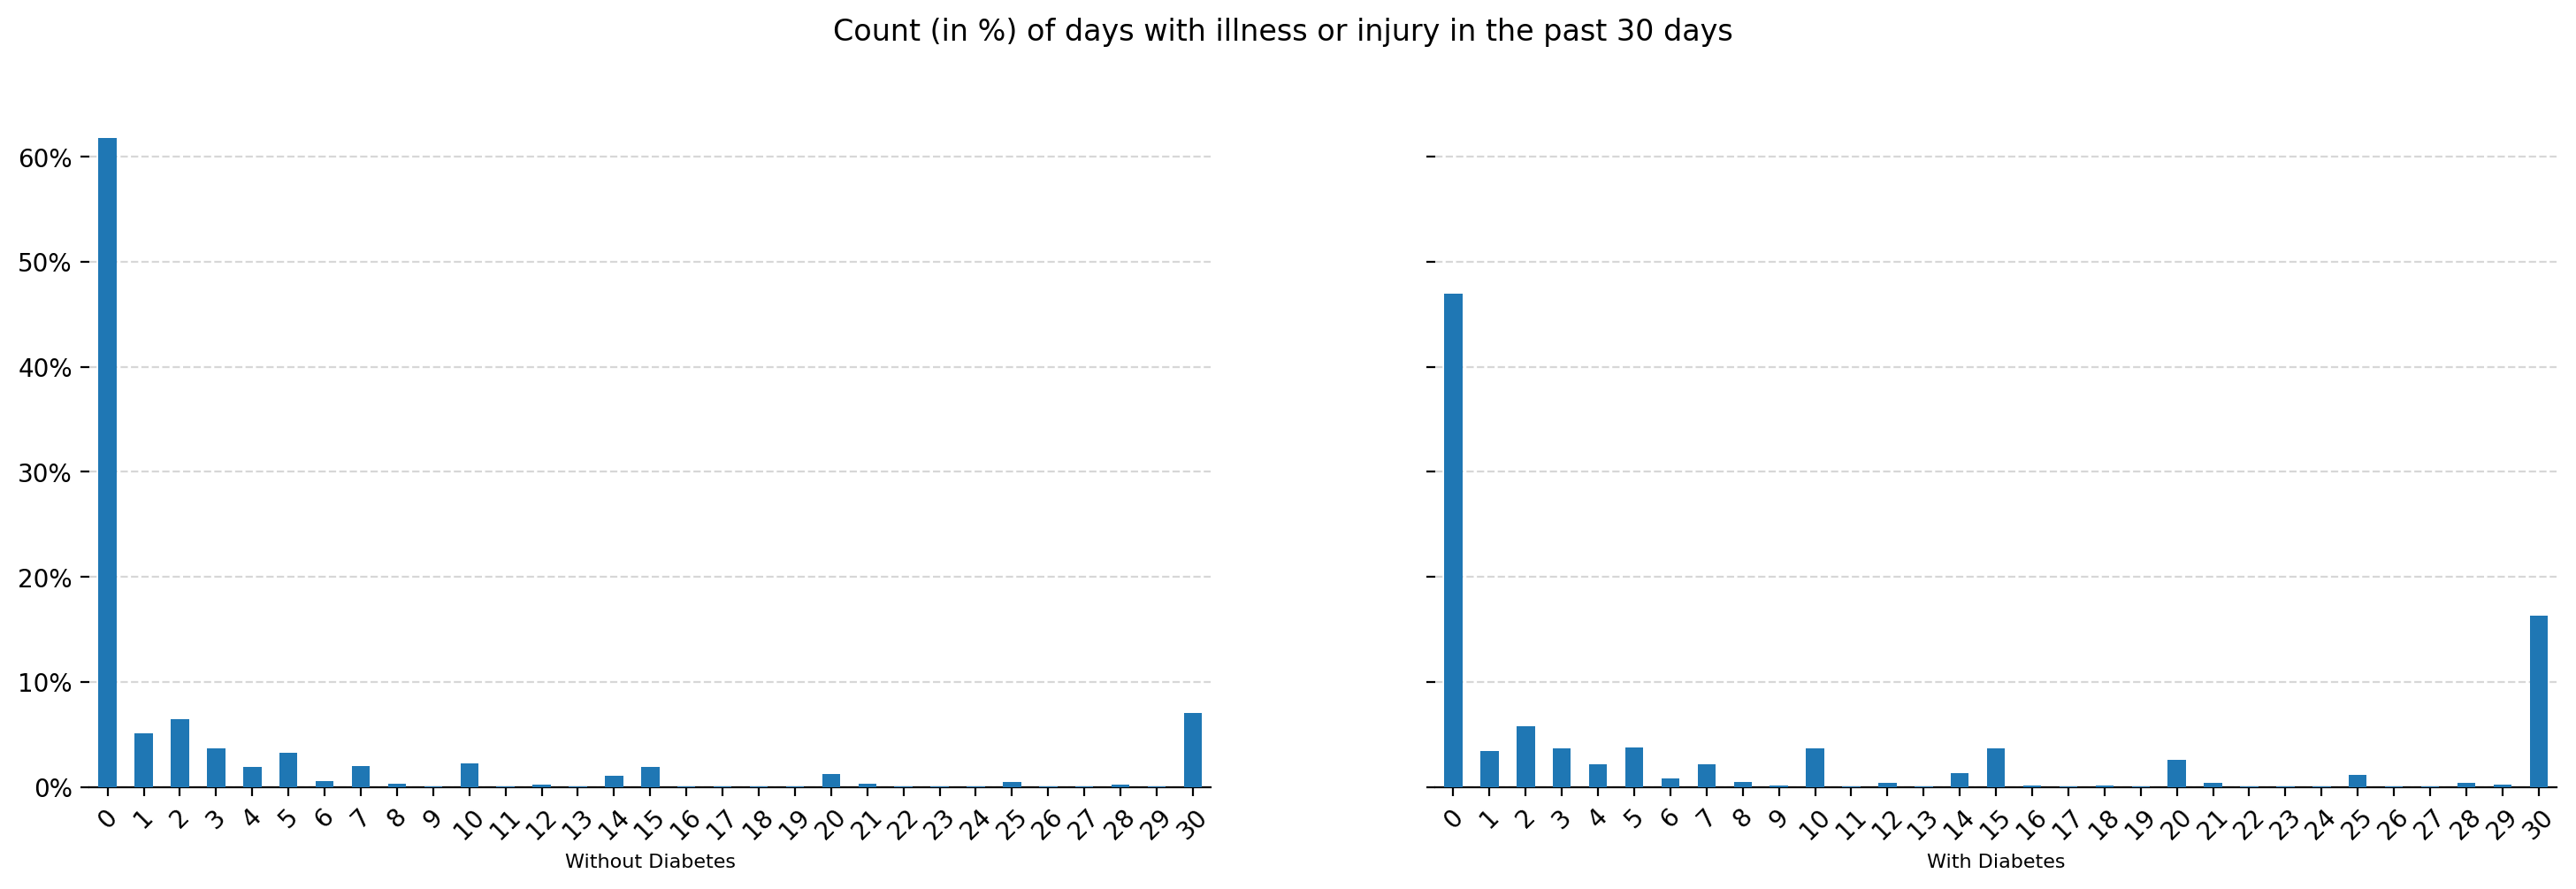

In [30]:
ratio = 5
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.6,ratio), dpi=200, sharey=True)
fig.suptitle('Count (in %) of days with illness or injury in the past 30 days')

(df[df['Diabetes_binary']==False]['PhysHlth']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

(df[df['Diabetes_binary']==True]['PhysHlth']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45);


The analysis of the dataset indicates that individuals diagnosed with Diabetes exhibit a significantly presence of days with some type of illness or injury compared to those without the condition

# Income

MetaData explains that is patient Annual household income in dollar, where:

* 1 = <10,000
* 2 = 10,000–15,000
* 3 = 15,000–20,000 	
* 4 = 20,000–25,000
* 5 = 25,000–35,000
* 6 = 35,000–50,000
* 7 = 50,001–75,000
* 8 = >75,000 


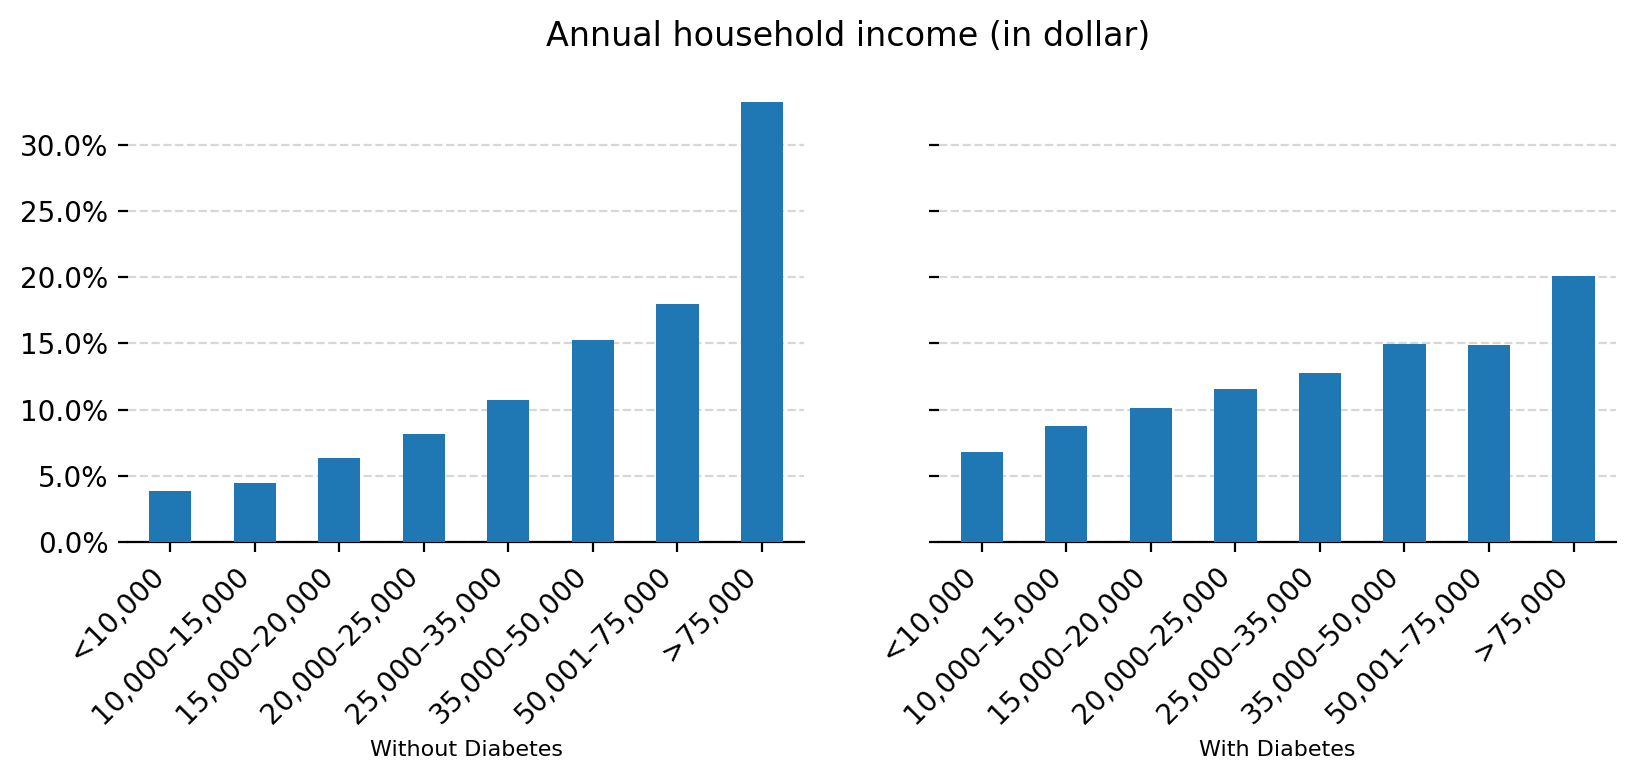

In [31]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Annual household income (in dollar)')
income_groups = ['<10,000', '10,000–15,000', '15,000–20,000', 
                 '20,000–25,000', '25,000–35,000', '35,000–50,000', 
                 '50,001–75,000', '>75,000']

(df[df['Diabetes_binary']==False]['Income']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(income_groups)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)


(df[df['Diabetes_binary']==True]['Income']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(income_groups)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right');
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.grid(axis='y', linestyle='--', alpha=.5)



According to the dataset analysis, there was a notable concentration of individuals diagnosed with Diabetes in the lower income tiers in contrast to those without the condition.

# Education

This variable is a answer to Education level question:

***What is the highest grade or year of school you completed?***

* 1 = Never attended school or only kindergarten
* 2 = Grades 1 through 8 (Elementary)
* 3 = Grades 9 through 11 (Some high school)
* 4 = Grade 12 or GED (High school graduate) 
* 5 = College 1 year to 3 years (Some college or technical school) 
* 6 = College 4 years or more (College graduate) 

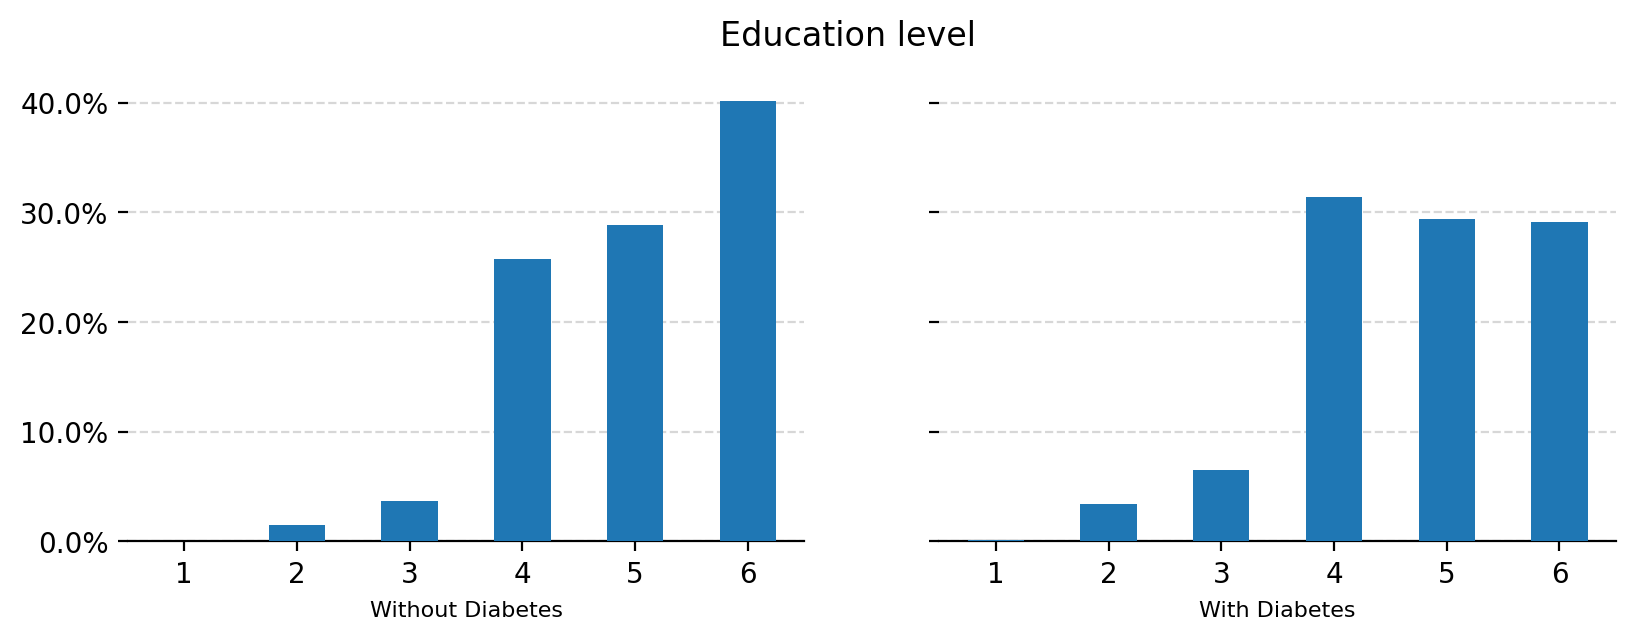

In [32]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Education level')


(df[df['Diabetes_binary']==False]['Education']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)


(df[df['Diabetes_binary']==True]['Education']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.grid(axis='y', linestyle='--', alpha=.5)



There are fewer individuals with a college degree who have been diagnosed with diabetes compared to those without the condition.

# PhysActivity

physical activity in past 30 days (not including job).

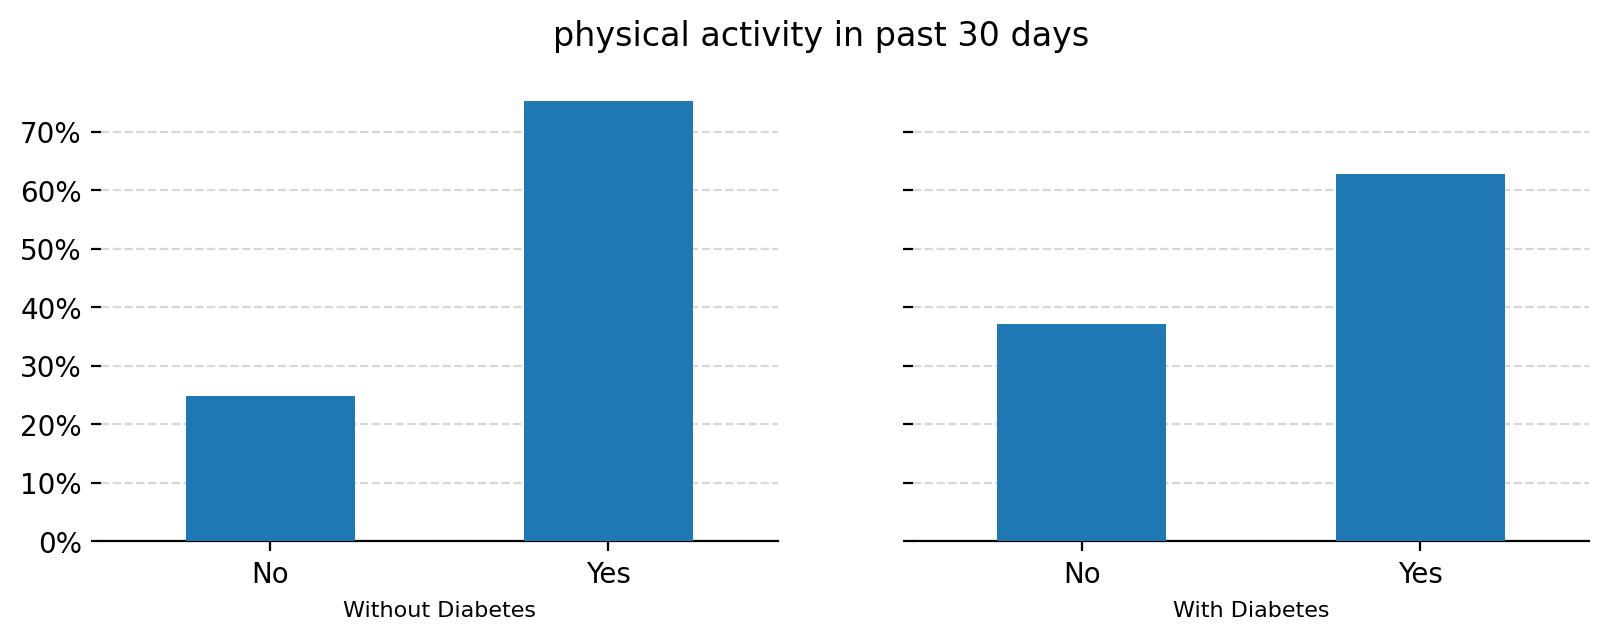

In [33]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('physical activity in past 30 days')

(df[df['Diabetes_binary']==False]['PhysActivity']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)

(df[df['Diabetes_binary']==True]['PhysActivity']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

The dataset analysis indicates that there are **more** individuals diagnosed with diabetes who report **lower** levels of physical activity, compared to those without the condition

# Addicional Analysis

## Smoker

*Have you smoked at least 100 cigarettes in your entire life?* [Note: 5 packs = 100 cigarettes] 

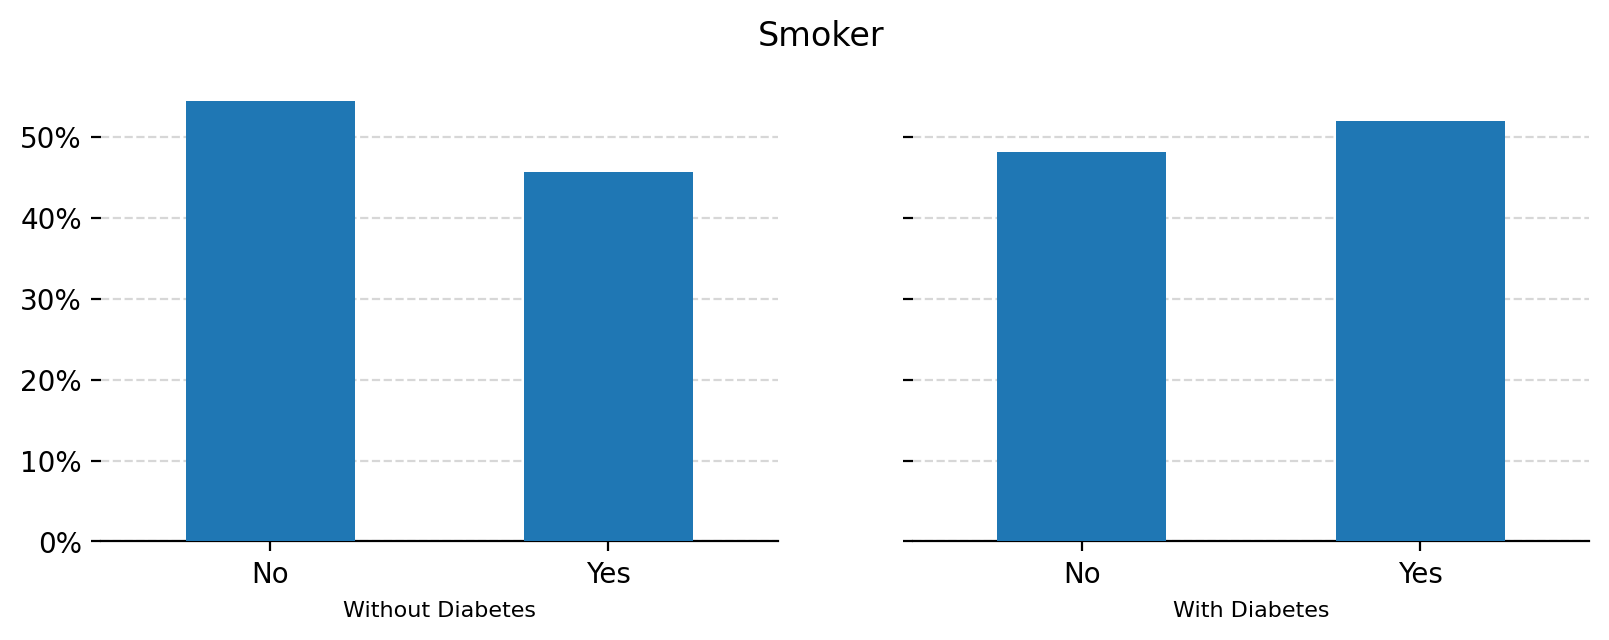

In [34]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Smoker')

(df[df['Diabetes_binary']==False]['Smoker']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)

(df[df['Diabetes_binary']==True]['Smoker']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

There a slight higher quantity of smoker in the Diabetic group.

## Stroke

*(Ever told) you had a stroke.*

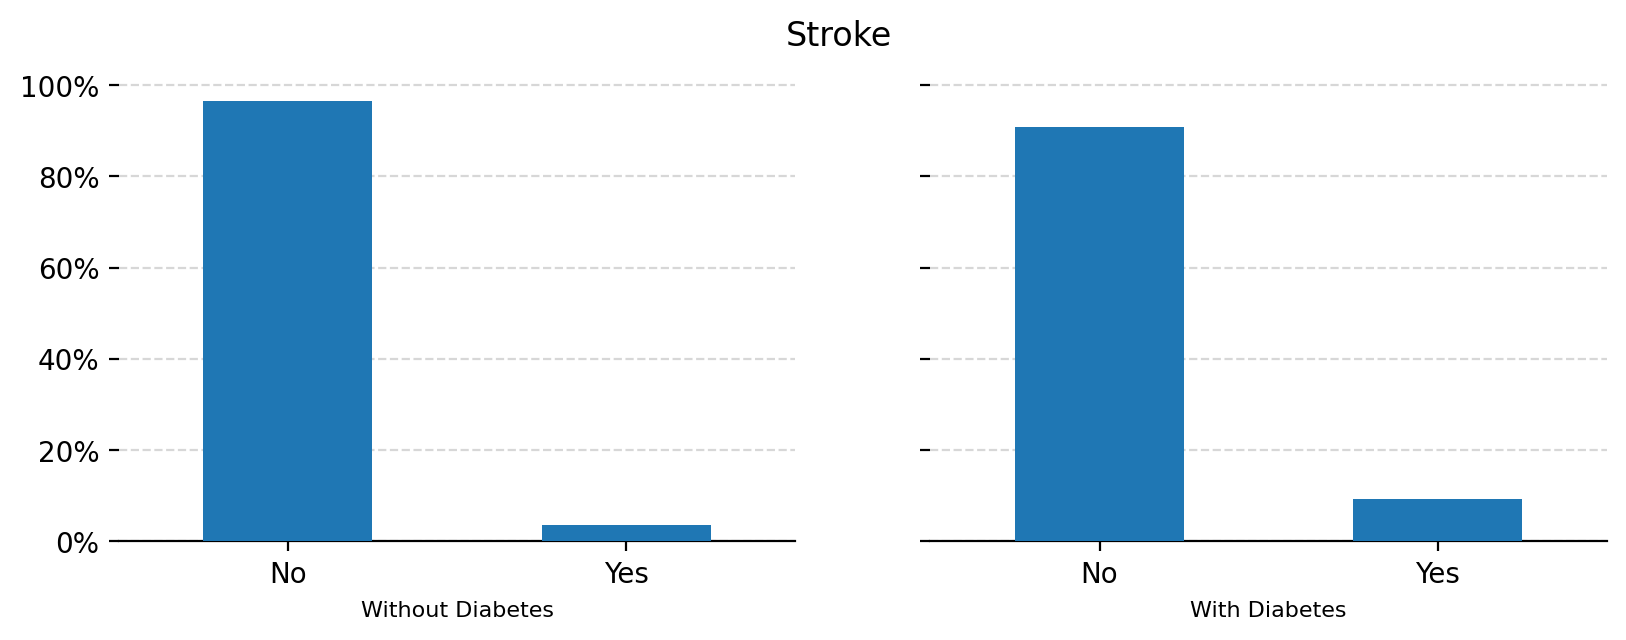

In [35]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Stroke')

(df[df['Diabetes_binary']==False]['Stroke']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)

(df[df['Diabetes_binary']==True]['Stroke']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

There a slight higher quantity of strokes in diabetic group.

## Alcohol Consumption
Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)

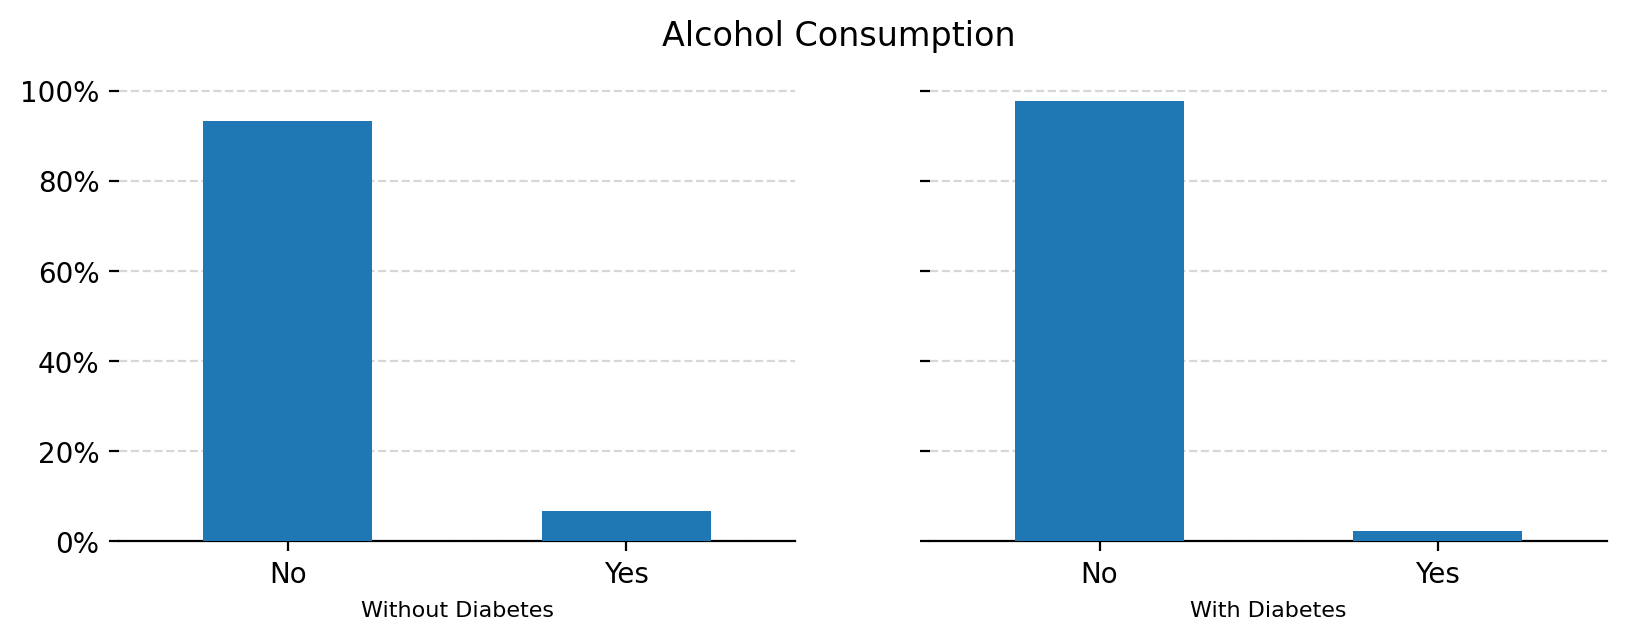

In [36]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Alcohol Consumption')

(df[df['Diabetes_binary']==False]['HvyAlcoholConsump']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)

(df[df['Diabetes_binary']==True]['HvyAlcoholConsump']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

There less heavy alcohol consume in the diabetic group.

## Cholesterol Check

Cholesterol check within past five years

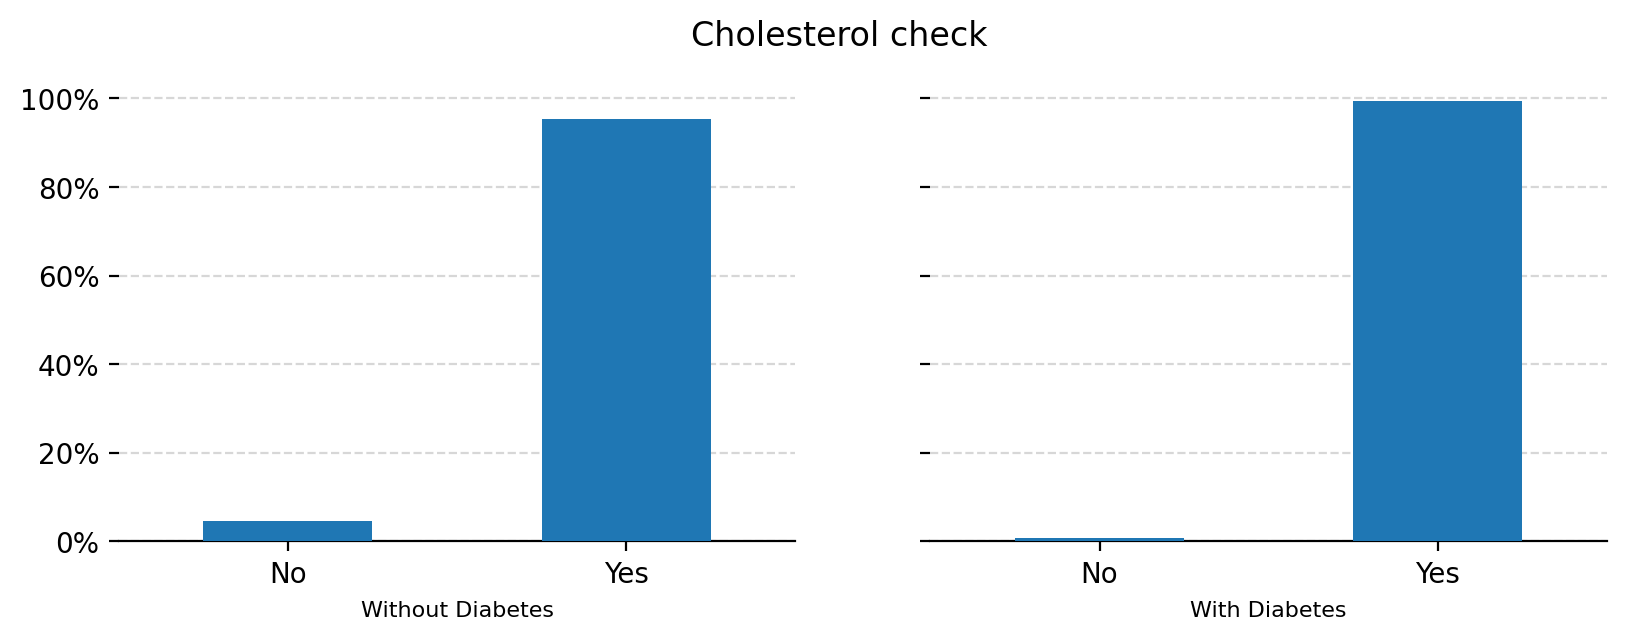

In [37]:
ratio = 3
fig, (ax, ax2) = plt.subplots(1,2, figsize=(ratio*3.2,ratio), dpi=200, sharey=True)
fig.suptitle('Cholesterol check')

(df[df['Diabetes_binary']==False]['CholCheck']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax,kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax.set_xlabel('Without Diabetes',size=8)
ax.set_xticklabels(["No", 'Yes'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y', linestyle='--', alpha=.5)

(df[df['Diabetes_binary']==True]['CholCheck']
 .value_counts(1)
 .sort_index()
 .plot(ax=ax2, kind='bar', zorder=3)).spines[['top','right', 'left']].set_visible(False)
ax2.set_xlabel('With Diabetes',size=8)
ax2.set_xticklabels(["No", 'Yes'])
ax2.grid(axis='y', linestyle='--', alpha=.5)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0);

The data show that diabetics check Cholesterol within past five years slight more than non diabetic

# Feature selection

In [38]:
# list of columns sorted by Pearson correlation
pear_coor = (df.drop('Diabetes_binary', axis=1)
   .corrwith(df.Diabetes_binary)
   .abs()
   .sort_values(ascending=False))
pear_coor

GenHlth                 0.276940
HighBP                  0.254318
DiffWalk                0.205302
BMI                     0.205086
HighChol                0.194944
BMI_bins                0.194376
Age                     0.177263
HeartDiseaseorAttack    0.168213
PhysHlth                0.156211
Income                  0.140659
Education               0.102686
PhysActivity            0.100404
Stroke                  0.099193
CholCheck               0.072523
HvyAlcoholConsump       0.065950
MentHlth                0.054153
Smoker                  0.045504
Veggies                 0.041734
Sex                     0.032724
AnyHealthcare           0.025331
Fruits                  0.024805
NoDocbcCost             0.020048
dtype: float64

In [39]:
pear_coor[pear_coor>0.05]

GenHlth                 0.276940
HighBP                  0.254318
DiffWalk                0.205302
BMI                     0.205086
HighChol                0.194944
BMI_bins                0.194376
Age                     0.177263
HeartDiseaseorAttack    0.168213
PhysHlth                0.156211
Income                  0.140659
Education               0.102686
PhysActivity            0.100404
Stroke                  0.099193
CholCheck               0.072523
HvyAlcoholConsump       0.065950
MentHlth                0.054153
dtype: float64

Pearson correlation coefficients sorted in decreasing order and absolute value.

If we set a threshold of 0.05, **Smoker** and below features are out.

Also, BMI performs better than binned BMI. To avoid redundant information, BMI_bins is out.

In [40]:
# how to do a contigency table 
pd.crosstab(df['Diabetes_binary'],df['HighBP'],margins=True)

HighBP,0,1,All
Diabetes_binary,,,
0,116522,77855,194377
1,8692,26405,35097
All,125214,104260,229474


In [41]:
df_X = df.drop('Diabetes_binary', axis=1)
df_y = df['Diabetes_binary']

This dataset don't have negative values. Contains almost only categorical features. Chi-squared is the most used in this situation.

In [42]:
# Chi² 2-sample Test
f_score = chi2(df_X, df_y)
chisquare = pd.DataFrame(f_score).T.set_index(df_X.columns).rename(columns={0:'ChiSqr_Score', 1:"ChiSqr_pValue"})
chi2_list = chisquare.sort_values(by='ChiSqr_Score', ascending=False)
chi2_list

,ChiSqr_Score,ChiSqr_pValue
PhysHlth,97988.761672,0.000000e+00
BMI,15507.736174,0.000000e+00
MentHlth,11419.584750,0.000000e+00
Age,8539.906340,0.000000e+00
HighBP,8098.548237,0.000000e+00
DiffWalk,7875.496177,0.000000e+00
GenHlth,7671.732832,0.000000e+00
HeartDiseaseorAttack,5822.145697,0.000000e+00
HighChol,4869.312739,0.000000e+00
Income,3377.099257,0.000000e+00


Mutual Information is other form to see the information gain of each feature.

In [43]:
# mutual information
mut_info = mutual_info_classif(df_X[bool_vars],df_y)
mut_df = pd.DataFrame(mut_info, columns=['Mutual_info'], index=df_X[bool_vars].columns)
mut_df.sort_values(by='Mutual_info',ascending=False)

,Mutual_info
HighBP,0.047400
CholCheck,0.046093
AnyHealthcare,0.040208
PhysActivity,0.036925
Veggies,0.034013
HighChol,0.033613
Fruits,0.026616
DiffWalk,0.019565
Smoker,0.019394
Sex,0.016735


[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) can help us determine the dependence between features and the target variable. Although the mutual information values may be small, they can provide valuable information. 

For instance, **CholCheck** has the highest mutual information score, but after examining the exploratory data analysis, we can deduce that diabetic individuals tend to get their cholesterol checked more frequently than non-diabetic individuals. This does not, however, imply any direct correlation between cholesterol checks and the cause of the disease and that is why this feature will not be used. The similar situation for **AnyHealthCare**.

In [44]:
# f_regression (F_test) for educational proposes
f_test = f_regression(df_X,df_y)
f_reg_df = pd.DataFrame(f_test).T.set_index(df_X.columns).rename(columns={0:'f_statistic', 1:"f_reg_pValues"})
f_reg_df.sort_values(by='f_statistic', ascending=False)

,f_statistic,f_reg_pValues
GenHlth,19061.436601,0.000000e+00
HighBP,15868.017696,0.000000e+00
DiffWalk,10097.616798,0.000000e+00
BMI,10075.425186,0.000000e+00
HighChol,9065.177413,0.000000e+00
BMI_bins,9010.331905,0.000000e+00
Age,7444.458687,0.000000e+00
HeartDiseaseorAttack,6682.140008,0.000000e+00
PhysHlth,5739.591424,0.000000e+00
Income,4631.714144,0.000000e+00


This is a regression scoring function, but this is a classification problem, this should not be used in this case.

## ANOVA test

In [45]:
# ANOVA
anova_test = f_classif(df_X[num_vars],df_y)
anova_df = pd.DataFrame(anova_test).T.set_index(df_X[num_vars].columns).rename(columns={0:'f_statistic', 1:"ANOVA_pValues"})
anova_df.sort_values(by='f_statistic', ascending=False)

,f_statistic,ANOVA_pValues
GenHlth,19061.433726,0.000000e+00
BMI,10163.821697,0.000000e+00
BMI_bins,9010.095612,0.000000e+00
Age,7444.479505,0.000000e+00
PhysHlth,5739.701978,0.000000e+00
Income,4631.703286,0.000000e+00
Education,2445.635014,0.000000e+00
MentHlth,674.909059,1.405305e-148


ANOVA statistic results show that the probability distribution of the variances are not equal for these features in the diabetic and non-diabetic groups.

## Information Value (IV) & Weight of evidence (WOE)

This [blog](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) share a good explanation of WOE and IV.

Where the IV score means:

* Less than 0.02 	Not useful for prediction
* 0.02 to 0.1 	Weak predictive Power
* 0.1 to 0.3 	Medium predictive Power
* 0.3 to 0.5 	Strong predictive Power
*  0.5 and higher 	Suspicious Predictive Power

In [46]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [47]:
iv,woe = iv_woe(df, 'Diabetes_binary')

Information value of HighBP is 0.532771
Information value of HighChol is 0.298296
Information value of CholCheck is 0.077694
Information value of BMI is 0.405771
Information value of Smoker is 0.015939
Information value of Stroke is 0.057511
Information value of HeartDiseaseorAttack is 0.16753
Information value of PhysActivity is 0.071942
Information value of Fruits is 0.004702
Information value of Veggies is 0.012756
Information value of HvyAlcoholConsump is 0.047814
Information value of AnyHealthcare is 0.005533
Information value of NoDocbcCost is 0.00295
Information value of GenHlth is 0.648408
Information value of MentHlth is 0.036244
Information value of PhysHlth is 0.171821
Information value of DiffWalk is 0.267031
Information value of Sex is 0.008216
Information value of Age is 0.395241
Information value of Education is 0.079076
Information value of Income is 0.151785
Information value of BMI_bins is 0.327313


In [48]:
iv.sort_values(by='IV', ascending=False)

,Variable,IV
0,GenHlth,0.648408
0,HighBP,0.532771
0,BMI,0.405771
0,Age,0.395241
0,BMI_bins,0.327313
0,HighChol,0.298296
0,DiffWalk,0.267031
0,PhysHlth,0.171821
0,HeartDiseaseorAttack,0.167530
0,Income,0.151785


IV score correlate with the pearson correlation in most of the features evalutation

In [49]:
# above threshold of 250 chi² score.
chisquare[chisquare['ChiSqr_Score']>250].index.to_list()

['HighBP',
 'HighChol',
 'BMI',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'HvyAlcoholConsump',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Age',
 'Education',
 'Income',
 'BMI_bins']

This is the top 16 features using the chi2 stat. BMI and BMI_bins have redundant information, Information Gain from from BMI_bins is higher than BMI, but BMI Pearson correlation, ChiSqr score and f statistic is higher than BMI_bins. We will test subsequent models with 2 columns groups using BMI in one group and BMI_bins in other.

This Feature selection was done arbitrarily to start the model baseline. 250 threshold cut in chi² score seen to agree with pearson correlation in this scenary where mutual information show gains from non direct cause relationship features.

# Prepare for the model

Now that EDA was performed, we need to build a Model to predict if a patient with this data is or not diabetic.

We will train the model in a selection of this dataset (X_train), test in separeted part of the same dataset not seen by the model during the training (X_test) and we will see its performance in a unseen dataset that is balanced (df2).


In [50]:
# function for the process the data if needed
def drop_duplicates_and_reset_index(df):
    dataframe = df.copy()
    dataframe = dataframe.drop_duplicates().reset_index(drop=True)
    return dataframe

# list of columns used from first exp (BMI group). Spoiler: better score for unseen dataset
cols_list = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education',
       'Income']

# comment above and uncomment below to see the BMI_bins group
# cols_list = ['HighBP', 'HighChol', 'BMI_bins', 'Smoker', 'Stroke',
#        'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
#        'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education',
#        'Income']


X = df[cols_list]
y = df['Diabetes_binary']

# on unseen dataset
df2_clean = data_clean(df2) 
df2_y = df2_clean['Diabetes_binary']
df2_X = df2_clean[cols_list]

#scaler
scaler = StandardScaler()
scaler.fit(X)

# on unseen dataset
df2_X_scaled = scaler.transform(df2_X)

# What score do i get if i say that all is non-diabetic?
Before we start, its helpful to set some references. How is the performance of random guesses?

In [51]:
nodiabetic_acc = accuracy_score(y, np.zeros_like(y))
nodiabetic_uac = roc_auc_score(y, np.zeros_like(y))

print(f'The accuracy for all 0 is {nodiabetic_acc:0.4f} and AUC is {nodiabetic_uac:0.4f} in the known and imbalaced dataset')

The accuracy for all 0 is 0.8471 and AUC is 0.5000 in the known and imbalaced dataset


The dataset is imbalaced, so guessing non-diabetic has a **higher** chance than diabetic.

In [52]:
# not seen balanced dataset
nodiabetic_acc = accuracy_score(df2_y, np.zeros_like(df2_y))
nodiabetic_uac = roc_auc_score(df2_y, np.zeros_like(df2_y))

print(f'The accuracy for all 0 is {nodiabetic_acc:0.4f} and AUC is {nodiabetic_uac:0.4f} in the unseen balanced dataset')

The accuracy for all 0 is 0.4918 and AUC is 0.5000 in the unseen balanced dataset


The dataset is balaced, so guessing non-diabetic has **equal** chance than diabetic.

# WIthout balancing dataset (Baseline)

In [53]:
# list of models
clf_rdf = RandomForestClassifier(random_state=508312)
clf_catboost = CatBoostClassifier(random_state=508312, verbose=False)
clf_xgb = XGBClassifier(random_state=508312)
clf_KNN = KNeighborsClassifier()
clf_gauss_nb = GaussianNB()
clf_lr = LogisticRegression(max_iter=500, random_state=508312)
clf_gb = GradientBoostingClassifier(random_state=508312)

In [54]:
def classifiers_models_test(clf_names, clf_list):
    '''For a given list of classfier name_list and object_list,
     return model, ACC, AUC and RMSE Dataframe'''
    
    info_clf = []
    for count, clf in enumerate(clf_list):

        clf.fit(X_train, y_train)

#         print(f'---------{clf_names[count]}--------') # used for troubleshooting

        # predict X_train
        y_pred = clf.predict(X_train)
        y_pred_proba = clf.predict_proba(X_train)[:,1]
        acc_score_xtr = accuracy_score(y_train, y_pred)
        auc_score_xtr = roc_auc_score(y_train,y_pred_proba)
        rmse_xtr = np.sqrt(mean_squared_error(y_train, y_pred))

        # predict X_test
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:,1]
        acc_score_xts = accuracy_score(y_test, y_pred)
        auc_score_xts = roc_auc_score(y_test,y_pred_proba)
        rmse_xts = np.sqrt(mean_squared_error(y_test, y_pred))

        # predict balanced unseen dataset df2
        y_pred = clf.predict(df2_X_scaled)
        y_pred_proba = clf.predict_proba(df2_X_scaled)[:,1]
        acc_score_un = accuracy_score(df2_y, y_pred)
        auc_score_un = roc_auc_score(df2_y,y_pred_proba)

        # RMSE score of the results in unseen dataset df2
        rmse_un = np.sqrt(mean_squared_error(df2_y, y_pred))
        info_clf.append([clf_names[count],acc_score_xtr,auc_score_xtr,rmse_xtr,acc_score_xts,auc_score_xts,rmse_xts,acc_score_un,auc_score_un,rmse_un])
        info_df = pd.DataFrame(info_clf, columns=['Model', 
                                'train_Accuracy','train_AUC', 'train_RMSE', 
                                'test_Accuracy','test_AUC', 'test_RMSE',
                                'unseen_Accuracy','unseen_AUC', 'unseen_RMSE'])
    return info_df

Diabetes_binary
1     35097
0    194377
Name: count, dtype: int64



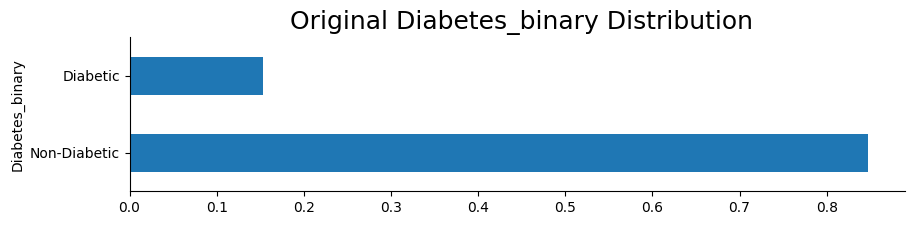


Diabetes_binary
1     31733
0    174793
Name: count, dtype: int64



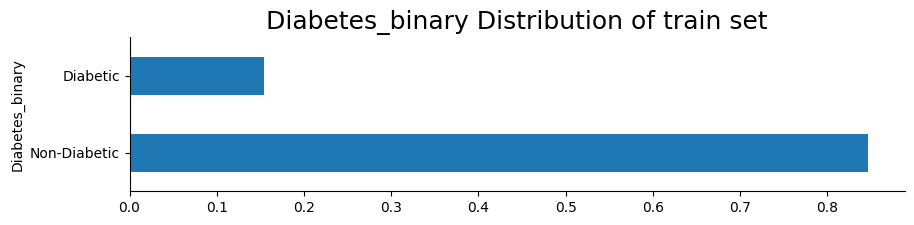


Imbalanced dataset


,Model,train_Accuracy,train_AUC,train_RMSE,test_Accuracy,test_AUC,test_RMSE,unseen_Accuracy,unseen_AUC,unseen_RMSE
0,RandomForest,0.983416,0.998015,0.128778,0.842514,0.764099,0.396846,0.914520,0.984570,0.292370
1,CatBoost,0.864811,0.838591,0.367680,0.858463,0.815495,0.376215,0.588340,0.845228,0.641607
2,XgBoost,0.861853,0.836735,0.371682,0.859073,0.813941,0.375403,0.584010,0.843720,0.644973
3,KNeighbors,0.874791,0.894388,0.353849,0.835018,0.711346,0.406179,0.653924,0.882001,0.588283
4,GaussianNB,0.774726,0.768106,0.474631,0.777802,0.768734,0.471379,0.667854,0.782006,0.576321
5,LogisticRegression,0.849264,0.803782,0.388248,0.856502,0.807526,0.378812,0.556091,0.816166,0.666265
6,GradientBoosting,0.853205,0.814605,0.383138,0.859421,0.816742,0.374938,0.563201,0.825097,0.660907


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, # predictive variables
    y, # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=508312, # we are setting the seed here
)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print(y.value_counts(ascending=True))
print()
y.value_counts(1).plot(kind='barh',figsize=(10, 2)).spines[['top', 'right']].set_visible(False);
plt.title(' Original Diabetes_binary Distribution', fontsize=18)
plt.yticks(ticks=[0,1], labels=['Non-Diabetic', 'Diabetic']);
plt.show()
print()

print(y_train.value_counts(ascending=True))
print()
y_train.value_counts(1).plot(kind='barh',figsize=(10, 2)).spines[['top', 'right']].set_visible(False);
plt.title('Diabetes_binary Distribution of train set', fontsize=18)
plt.yticks(ticks=[0,1], labels=['Non-Diabetic', 'Diabetic']);
plt.show()

clf_names = ['RandomForest', 'CatBoost', 'XgBoost', 'KNeighbors', 'GaussianNB', 'LogisticRegression', 'GradientBoosting']
clf_list = [clf_rdf, clf_catboost, clf_xgb, clf_KNN, clf_gauss_nb, clf_lr, clf_gb]

print()
imbalanced_perf = classifiers_models_test(clf_names,clf_list)
print('Imbalanced dataset')
imbalanced_perf

The best performance in the unseen dataset is from RandomForest model with **0.914520** Accuracy.

Some models seen to be overfitting.

# Testing Under and Over sampling techniques

Is know that the unseen dataset is balanced. Balancing the dataset where the model will be trained will result in best performance? Tranforming the train set in a balanced dataset before the model fit.

***Recall*** is very important in domains such as medical (e.g., identifying cancer), where you really want to minimize the chance of missing positive cases (predicting false negatives). These are typically cases where missing a positive case has a much bigger cost than wrongly classifying something as positive.

The Recall score of this model is 0.91 and we can improve to avoid False negative. This can lower the performance of the model, but is less problematic for the community (and the patient) a False positive than a False negative.

In [56]:
info_clf = []

clf = RandomForestClassifier(random_state=508312, class_weight= {0: 1, 1:20})
clf.fit(X_train, y_train)

# predict X_train
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)[:,1]
acc_score_xtr = accuracy_score(y_train, y_pred)
auc_score_xtr = roc_auc_score(y_train,y_pred_proba)
rmse_xtr = np.sqrt(mean_squared_error(y_train, y_pred))

# predict X_test
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]
acc_score_xts = accuracy_score(y_test, y_pred)
auc_score_xts = roc_auc_score(y_test,y_pred_proba)
rmse_xts = np.sqrt(mean_squared_error(y_test, y_pred))

# predict balanced unseen dataset df2
y_pred = clf.predict(df2_X_scaled)
y_pred_proba = clf.predict_proba(df2_X_scaled)[:,1]
acc_score_un = accuracy_score(df2_y, y_pred)
auc_score_un = roc_auc_score(df2_y,y_pred_proba)

# RMSE score of the results in unseen dataset df2
rmse_un = np.sqrt(mean_squared_error(df2_y, y_pred))
info_clf.append(['RandomForest',acc_score_xtr,auc_score_xtr,rmse_xtr,acc_score_xts,auc_score_xts,rmse_xts,acc_score_un,auc_score_un,rmse_un])
info_df = pd.DataFrame(info_clf, columns=['Model', 
                        'train_Accuracy','train_AUC', 'train_RMSE', 
                        'test_Accuracy','test_AUC', 'test_RMSE',
                        'unseen_Accuracy','unseen_AUC', 'unseen_RMSE'])

print('RandomForest:')
print(classification_report(df2_y, y_pred, target_names=['non-diabetic','diabetic']))

target_names = ['non-diabetic','diabetic']
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['white', '#011b7a'])
cm = confusion_matrix(df2_y, y_pred)
plot_confusion_matrix(cm, target_names, 'RandomForest\nConfusion Matrix', custom_cmap, normalize=False)

info_df

RandomForest:
              precision    recall  f1-score   support

non-diabetic       0.92      0.96      0.94     33960
    diabetic       0.96      0.92      0.94     35097

    accuracy                           0.94     69057
   macro avg       0.94      0.94      0.94     69057
weighted avg       0.94      0.94      0.94     69057



NameError: name 'plot_confusion_matrix' is not defined

By adjusting the class weights of the model, the model's recall performance improved by 1%.

C:\Users\djhar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\djhar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest:
              precision    recall  f1-score   support

non-diabetic       0.49      1.00      0.66     33960
    diabetic       0.00      0.00      0.00     35097

    accuracy                           0.49     69057
   macro avg       0.25      0.50      0.33     69057
weighted avg       0.24      0.49      0.32     69057



C:\Users\djhar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djhar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djhar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469

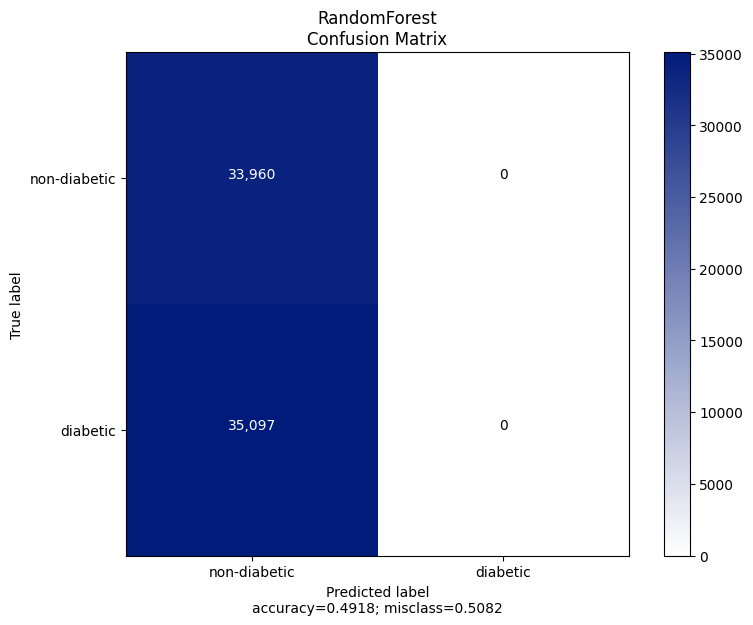

,Model,train_Accuracy,train_AUC,train_RMSE,test_Accuracy,test_AUC,test_RMSE,unseen_Accuracy,unseen_AUC,unseen_RMSE
0,RandomForest,0.958146,0.992605,0.204583,0.814406,0.784341,0.430806,0.491768,0.690314,0.712904


In [ ]:
info_clf = []

clf = RandomForestClassifier(random_state=508312, class_weight= {0: 1, 1:12},min_impurity_decrease=1e-07)
clf.fit(X_train, y_train)

# predict X_train
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)[:,1]
acc_score_xtr = accuracy_score(y_train, y_pred)
auc_score_xtr = roc_auc_score(y_train,y_pred_proba)
rmse_xtr = np.sqrt(mean_squared_error(y_train, y_pred))

# predict X_test
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]
acc_score_xts = accuracy_score(y_test, y_pred)
auc_score_xts = roc_auc_score(y_test,y_pred_proba)
rmse_xts = np.sqrt(mean_squared_error(y_test, y_pred))

# predict balanced unseen dataset df2
y_pred = clf.predict(df2_X_scaled)
y_pred_proba = clf.predict_proba(df2_X_scaled)[:,1]
acc_score_un = accuracy_score(df2_y, y_pred)
auc_score_un = roc_auc_score(df2_y,y_pred_proba)

# RMSE score of the results in unseen dataset df2
rmse_un = np.sqrt(mean_squared_error(df2_y, y_pred))
info_clf.append(['RandomForest',acc_score_xtr,auc_score_xtr,rmse_xtr,acc_score_xts,auc_score_xts,rmse_xts,acc_score_un,auc_score_un,rmse_un])
info_df = pd.DataFrame(info_clf, columns=['Model', 
                        'train_Accuracy','train_AUC', 'train_RMSE', 
                        'test_Accuracy','test_AUC', 'test_RMSE',
                        'unseen_Accuracy','unseen_AUC', 'unseen_RMSE'])

print('RandomForest:')
print(classification_report(df2_y, y_pred, target_names=['non-diabetic','diabetic']))

target_names = ['non-diabetic','diabetic']
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['white', '#011b7a'])
cm = confusion_matrix(df2_y, y_pred)
plot_confusion_matrix(cm, target_names, 'RandomForest\nConfusion Matrix', custom_cmap, normalize=False)

info_df

In [ ]:
from sklearn.metrics import f1_score
f1_score(df2_y, y_pred, average="weighted")

0.32422668257665327

By adjusting the class weights and the minimum decrease of the impurity of the model, the model's recall performance improved by 5% with a lower trade-off in accuracy (4%)

# Conclusion

* The features that correlated better with the target are: HighBP, HighChol, BMI, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, HvyAlcoholConsump, GenHlth , MentHlth, PhysHlth, DiffWalk, Age, Education, Income.

* The model with best performance for the **unseen balanced** dataset is the **Random Forest** Model with **SMOTE** undersampling.

* After the final tunning our model performance has 0.91 Accuracy with recall of 0.96 for the diabetic class
